<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Downloading-Data" data-toc-modified-id="Downloading-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Downloading Data</a></span></li><li><span><a href="#Warm-up:-Univariate-Autoregressive-Models" data-toc-modified-id="Warm-up:-Univariate-Autoregressive-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Warm-up: Univariate Autoregressive Models</a></span><ul class="toc-item"><li><span><a href="#Why-does-this-matter?" data-toc-modified-id="Why-does-this-matter?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Why does this matter?</a></span><ul class="toc-item"><li><span><a href="#Non-Stationary-Model" data-toc-modified-id="Non-Stationary-Model-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Non-Stationary Model</a></span></li></ul></li></ul></li><li><span><a href="#Higher-order-dynamics:-The-Samuelson-Multiplier-Accelerator-Model" data-toc-modified-id="Higher-order-dynamics:-The-Samuelson-Multiplier-Accelerator-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Higher order dynamics: The Samuelson Multiplier-Accelerator Model</a></span><ul class="toc-item"><li><span><a href="#Stability-and-the-State-Space-Representation" data-toc-modified-id="Stability-and-the-State-Space-Representation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Stability and the State Space Representation</a></span></li><li><span><a href="#How-does-it-forecast?" data-toc-modified-id="How-does-it-forecast?-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>How does it forecast?</a></span></li></ul></li><li><span><a href="#On-to-VAR-models" data-toc-modified-id="On-to-VAR-models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>On to VAR models</a></span><ul class="toc-item"><li><span><a href="#VAR-models-as-a-linear-state-space" data-toc-modified-id="VAR-models-as-a-linear-state-space-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>VAR models as a linear state space</a></span></li><li><span><a href="#VAR-models-as-a-2d-convolution" data-toc-modified-id="VAR-models-as-a-2d-convolution-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>VAR models as a 2d convolution</a></span></li><li><span><a href="#VAR-Models" data-toc-modified-id="VAR-Models-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>VAR Models</a></span></li><li><span><a href="#Var3(4)" data-toc-modified-id="Var3(4)-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Var3(4)</a></span><ul class="toc-item"><li><span><a href="#Forecasts" data-toc-modified-id="Forecasts-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Forecasts</a></span></li><li><span><a href="#Impulse-Response-Functions" data-toc-modified-id="Impulse-Response-Functions-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>Impulse Response Functions</a></span></li></ul></li><li><span><a href="#VAR10" data-toc-modified-id="VAR10-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>VAR10</a></span><ul class="toc-item"><li><span><a href="#Does-stability-matter-for-forecasting?" data-toc-modified-id="Does-stability-matter-for-forecasting?-5.5.1"><span class="toc-item-num">5.5.1&nbsp;&nbsp;</span>Does stability matter for forecasting?</a></span><ul class="toc-item"><li><span><a href="#1-Year-Forecasts" data-toc-modified-id="1-Year-Forecasts-5.5.1.1"><span class="toc-item-num">5.5.1.1&nbsp;&nbsp;</span>1 Year Forecasts</a></span></li><li><span><a href="#2.5-year-forecasts" data-toc-modified-id="2.5-year-forecasts-5.5.1.2"><span class="toc-item-num">5.5.1.2&nbsp;&nbsp;</span>2.5 year forecasts</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#VAR-32" data-toc-modified-id="VAR-32-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>VAR 32</a></span></li><li><span><a href="#Restrict-the-model-to-stationary-VAR-using-Heaps-Prior-and-Transform" data-toc-modified-id="Restrict-the-model-to-stationary-VAR-using-Heaps-Prior-and-Transform-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Restrict the model to stationary VAR using Heaps Prior and Transform</a></span></li><li><span><a href="#Var(32,4)" data-toc-modified-id="Var(32,4)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Var(32,4)</a></span></li></ul></div>

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_utilities import download_raw_data
from plotting import configure_matplotlib, quantecon_param_plot, plot_eigenvalues
from global_vars import FRED_VARS, BIS_VARS, YAHOO_VARS, COL_NAMES, PREPROCESS_BY_COL, PREPROCESSING_CODES, \
    VARIABLE_TYPES

from scipy import stats
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt

import os

from TimeSeriesTools.transformers import DifferenceTransformer, LogTransformer, PandasStandardScaler
from TimeSeriesTools.stats import ADF_test_summary
from VAR_to_statespace import stability_analysis, statespace_forecast, bayesian_impulse_response_function
from heaps_transform import A_to_P, P_to_params, build_A_matrix

configure_matplotlib()

In [3]:
def preprocess_VAR_data(fpath, pg, test_size=20):
    df = pd.read_csv(fpath, index_col=0, parse_dates=[0], infer_datetime_format=True)
    rename_dict = {v:k for k, v in pg.name.to_dict().items()}
    df.rename(columns=rename_dict, inplace=True)
    stock_vars = df.loc[:, pg.agg_type == 'stock'].copy()
    flow_vars = df.loc[:, pg.agg_type == 'flow'].copy()
    
    diff_cols = set(pg.index[pg.preprocessing_type == 'd'])
    diff_diff_cols = set(pg.index[pg.preprocessing_type == 'dd'])
    log_cols = set(pg.index[pg.preprocessing_type == 'l'])
    log_diff_cols = set(pg.index[pg.preprocessing_type == 'ld'])
    log_diff_diff_cols = set(pg.index[pg.preprocessing_type == 'ldd'])
    
    all_log_cols = list((log_cols.union(log_diff_cols).union(log_diff_diff_cols)))
    all_diff_cols = list((diff_cols.union(diff_diff_cols).union(log_diff_cols).union(log_diff_diff_cols)))
    all_ddiff_cols = list((log_diff_diff_cols.union(log_diff_diff_cols)))
                           
    pipeline = Pipeline([('log_transformation', LogTransformer(lamb=0, columns=all_log_cols)),
                         ('first_difference', DifferenceTransformer(columns=all_diff_cols)),
                         ('second_difference', DifferenceTransformer(columns=all_ddiff_cols))])

    df = stock_vars.resample('QS-OCT').last().join(flow_vars.resample('QS-OCT').sum())
    return df, pipeline


# Introduction

This is a notebook about Vector Autoregressive models in PyMC. It takes as a starting point [this excellent blog post by Ricardo Vieira](https://www.pymc-labs.io/blog-posts/bayesian-vector-autoregression/). If you haven't read that post, I strongly recommend it. It will give you everything you need to understand how to quickly implement a Bayesian VAR in PyMC.

This notebook goes one step beyond, and looks into the challenges one faces when trying to fit a large-scale VAR. To do this, we will use a dataset of 30 economic time series, selected by [Koop (2013)](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.1270). 

We will also look at two different representations of the VAR. First, we will show that all autoregressive time series models can be represented as a 2D convolution. This is convenient, because it allows us to take advantage of highly optimized convolution routines in Aesara for fast sampling and easy-to-read code. Well, easy once you understand what is going on.

Second, we will show that all autoregressive models can be written recursively, in the so-called linear state-space form. We will see that this is convenient for forecasting and analysis. In particular, we will:

1. Analyze the dynamics of the VAR model using impulse response functions
2. Further understand these dynamics by examining the eigenvalues of the linear state space transition matrix
3. Explore the connection between the stability of the VAR and the values of the eigenvalues

We will discover that as we add more lags and more equations, the model becomes harder and harder to sample. In addition, the solutions we do find will become increasing non-sensical, either exploding to infinity, or rapidly oscillating between positive and negative values. These results are no consistent with observed economic time series, which are not (typically) prone to huge jumps.

We will solve this problem using the Heaps prior and transformation, proposed in [Heaps (2022)](https://arxiv.org/pdf/2004.09455.pdf). In this paper, Heaps proposes a scheme for sampling only from stationary VAR models, allowing us to get meaningful results, even in the case of large models.

# Downloading Data

All the data for this notebook will downloaded by these cells to `./data/`. It will also check if that file exists on future runs, to avoid spamming these APIs. It also transforms the data according to Koops (2013), and splits it into a train and test set.

In [4]:
from sklearn.pipeline import Pipeline

preprocessing_guide = (pd.DataFrame([PREPROCESS_BY_COL, VARIABLE_TYPES, {v:k for k, v in COL_NAMES.items()}], 
                                    index=['preprocessing_type', 'agg_type', 'name'])
                       .T
                       .assign(preprocessing_type = lambda x: x.preprocessing_type.apply(PREPROCESSING_CODES.get)))

download_raw_data(list(FRED_VARS.values()))
download_raw_data(list(YAHOO_VARS.values()), source='yahoo')
download_raw_data(list(BIS_VARS.values()), source='bis')

df, pipe = preprocess_VAR_data('data/VAR_data_raw.csv', preprocessing_guide)
df = pipe.fit_transform(df.dropna())
train_df = df.iloc[:-20, :].copy()
test_df = df.iloc[-20:, :].copy()

scaler = PandasStandardScaler()
train_df = scaler.fit_transform(train_df)
test_df = scaler.transform(test_df)


All requested variables have been downloaded
All requested variables have been downloaded
All requested variables have been downloaded


/tmp/ipykernel_244654/3061235221.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(fpath, index_col=0, parse_dates=[0], infer_datetime_format=True)


# Warm-up: Univariate Autoregressive Models

Autoregressive (AR) models model future observations of a time series as a function of past observations. The "order" of the model tells how many past values should be considered when forecasting. For example, an autoregressive model of order 2, AR(2), would be written:

$$\hat{y}_{t+1} = \phi_1 y_t + \phi_2 y_{t-1} + \epsilon_t$$

The simplest model is of course the humble AR(1). Here it is:

$$\hat{y}_{t+1} = \phi_1 y_t + \epsilon_t$$

Note that the parameter in the AR(1) model is typically written as $\rho$, I'll use $\phi_1$ just to be consistent when we move to the VAR models.

It is a useful model to study to introduce the notion of *stability*. We will call a time series model "stable" or "stationary" if the mean and covariance are not functions of time. In practial terms, this means that the system always returns to a "steady state". It doesn't diverge to infinity over time. To establish a condition for this, notice that we could recursively substitution this equation back into itself. In particular, we know that $y_t = \phi_1 y_{t-1} + \epsilon_{t-1}$, and $y_{t-1} = \phi_1 y_{t-1} + \epsilon_{t-2}$, and so on. Making these substitutions:

$$\begin{align} y_{t+1} &= \phi_1 (\phi_1 y_{t-1} + \epsilon_{t-1}) + \epsilon_t \\
                        &= \phi_1 (\phi_1 (\phi_1 y_{t-2} + \epsilon_{t-2}) + \epsilon_{t-1}) + \epsilon_t \end{align}$$
                        
Using our considerable powers of pattern recoginition, we see that an AR(1) process can be written:

$$y_t = \phi_1^t y_0 + \sum_{\tau=0}^t \phi_1^\tau \epsilon_{t-\tau}$$

Next we will take expectations. We haven't said anything about $\epsilon_t$ up to this point, but we assume they are independent over time, with a mean of zero and constant variance $\sigma^2$. Also, assume we know $y_0$, the initial state of the system. We can now compute the moments of the system:
$$\mathbb E[y_t]= \phi_1^t y_0$$
$$\begin{align}\text{Var}(y_t) &= \phi_1^{2t}\text{Var}(y_0) + \sum_{t=0}^\tau \phi_1^{2\tau} \text{Var}(\epsilon_{t-\tau}) \\
                               &= 0 + \sum_{\tau=0}^t \phi_1^{2\tau} \sigma^2 \end{align}$$

What if time rolls on forever? We can compute limits of these moments:

$$\lim_{t \to \infty} \mathbb E[y_t] = 0$$
$$\lim_{t \to \infty} \text{Var}(y_t) = \sum_{t=0}^\infty \phi_1^{2t} \sigma^2 = \frac{\sigma^2}{1 - \phi_1^2}$$

To get the last result, we assume that $|\phi_1| < 1$. Indeed, this assumption is our main conclusion. An AR(1) process is stationary, i.e. has a stable (finite) variance, if and only if the value of $\phi_1$ is less than 1 in absolute value. To illustrate the point, I plot some trajectories when $\phi_1 = \{0.5, 1.0, 1.5\}$.

As usual in statistics, something like 50 is equal to infinity. We see that after this many time steps, the AR(1) with $|\phi_1| > 1$ diverges. $\phi_1 = 0.8$ oscillates randomly around 0, but remains bounded between something like -6 and 6. $\phi_1 = 1$, finally, is a pure gaussian random walk.

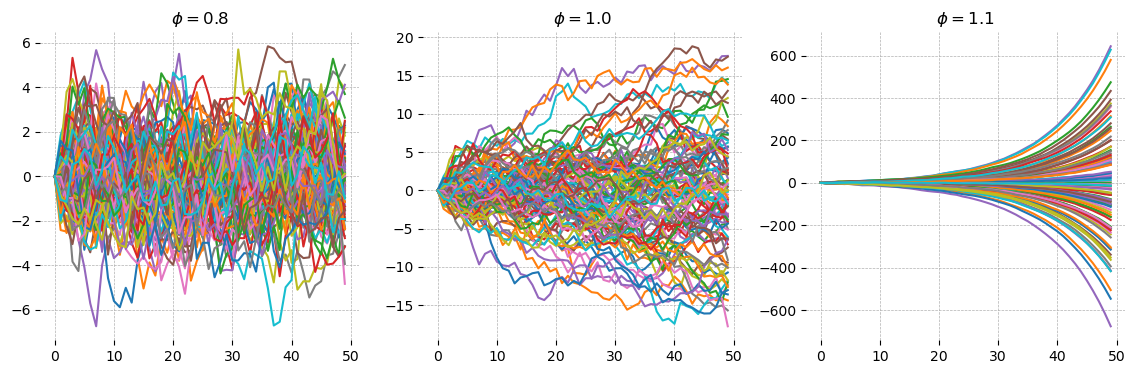

In [5]:
fig, ax = plt.subplots(1, 3)
phis = [0.8, 1.0, 1.1]
N = 100
T = 50
x0 = 0
epsilons = np.random.normal(0, 1, size=(N, T))
y = np.zeros_like(epsilons)
for axis, phi in zip(fig.axes, phis):
    y[:, 0] = x0
    for t in range(1, T):
        y[:, t] = phi * y[:, t-1] + epsilons[:, t]
    axis.plot(y.T)
    axis.set_title(f'$\phi = {phi}$')


## Why does this matter?

This matters because when $\phi$ is not stationary, the implied dynamics of our model will not be "scientifically credible". Small perturbations to the model will imply huge changes to the future trajectory of the series. Practically, this may or may not matter. Look at the above graph when $\phi = 1.1$, for example. If we are only forecasting (i.e., generating sample paths from the model) for a short time period, say 10 steps, the exponential blowup isn't so bad. We might be able to get good results. In this notebook, we will work with quartrely data, where a long-term forcast of 3-5 years is only 12-20 steps. If we were working with daily stock returns, however, a quaterly forecast would be totally out of the question in the presence of non-stationary dynamics! The notion of "long" and "short" term obviously need to scale with the frequency of the data.

Finally, as a practical concern, the sampler struggles more with non-stationary dynamics. Exponents are harsh mistresses, and can easily cause underflow. See if you can get the following model to sample for different values of `T`. I was able to get a great trace and accurate estimate with T=30. At T=50 I got multiprocessing errors, but was able to fit the model sequentially. At T=100, the wheels totally fell off the cart and I began to get underflows.

We can avoid all this heartache by making the data stationary first, usually by differencing, taking logs, or both.

### Non-Stationary Model

You can have a try sampling this by uncommenting the code. It's possible but not easy.

In [6]:
#T = 30
# T = 50
# T = 100

# y_nonstation = np.zeros(T)
# for t in range(1, T):
#     y_nonstation[t] = 1.2 * y_nonstation[t-1] + np.random.normal()
    
# with pm.Model() as non_stationary_model:
#     params = pm.Normal('phi', mu=1.0, sigma=0.1, size=1)
#     sigma = pm.HalfCauchy('sigma', beta=1.0)
#     x0 = pm.Normal.dist(mu=0, sigma=10.0, size=(1,))
    
#     likelihood = pm.AR('AR', rho=params, sigma=sigma, init_dist=x0, observed=y_nonstation, constant=False)
#     non_stationary_trace = pm.sample(cores=1, chains=4)

# Higher order dynamics: The Samuelson Multiplier-Accelerator Model

[This QuantEcon lecture](https://python.quantecon.org/samuelson.html) lays out the math behind the multiplier-accelerator model of [Paul Samuelson (1939)](https://www.jstor.org/stable/1927758). It's extremely well done, and I refer the interested reader there. Here, I will give a brief overview.

We seek to model economic growth, $Y_t$, which we will take to be the GDP. GDP simply counts up everything produced over an interval of time. We assume the economy is a closed system, so everything produced is used. There are three uses for stuff: households can consume it (consumption), $C_t$, households can save it (investment), $I_t$, or the government can consume it, $G_t$. Thus we  have an accounting identity:

$$Y_t = C_t + I_t + G_t$$

Samuelson takes consumption and investment to be functions of GDP. First, the richer we are, the more we will consume:
$$C_t = a Y_{t-1} + \gamma$$

Finally, our investment decision will be a function of the velocity of growth. When the economy is growing, we throw money into the stock market. When there is recession, we pull out money out of investments and consume it instead.
$$I_t = b (Y_{t-1} - Y_{t-2})$$

We will take government spending as exogenous, so $G_t = g$. These three equations imply a single equation for GDP:

$$Y_t = (g + \gamma) + (a + b) Y_{t-1} - b Y_{t-2}$$

Assuming this relationship isn't perfect, we can add an error term, and define $\phi_0 = g + \gamma$, $\phi_1 = a + b$, $\phi_2 = -b$, and we have the following AR(2) model:

$$Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \epsilon_t$$

We can estimate this using PyMC. First load GDP from the raw data.

<Axes: >

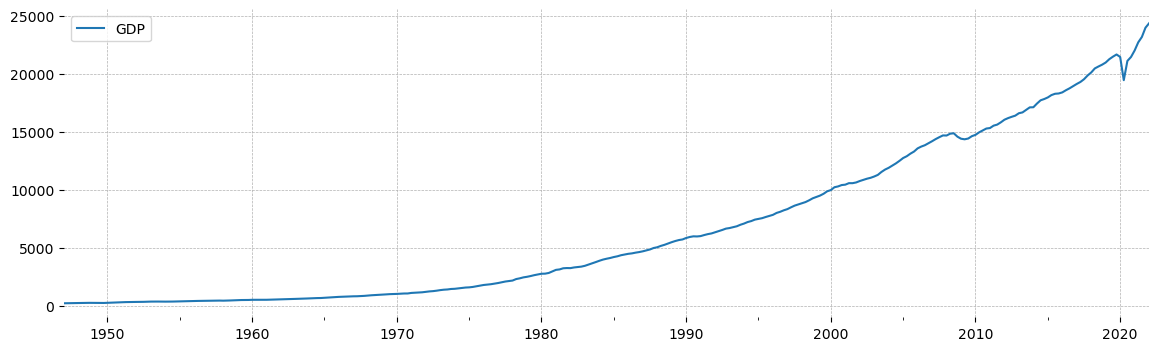

In [7]:
gdp = pd.read_csv('data/VAR_data_raw.csv', index_col=0, parse_dates=[0])['GDP'].dropna().to_frame()
gdp.plot()

<Axes: >

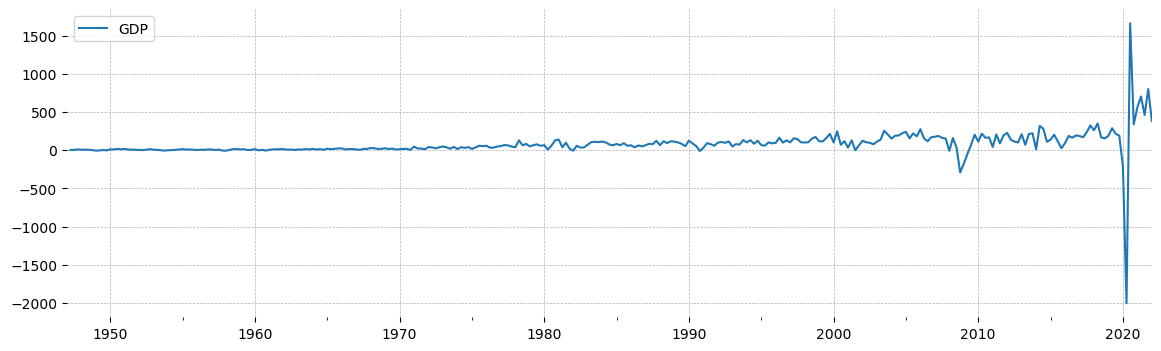

In [8]:
diff_trans = DifferenceTransformer()
gdp_diff = diff_trans.fit_transform(gdp)
gdp_diff.plot()

Since GDP is not stationary (it's growing exponentially over time), we can instead model the growth rate. It's easy to show that:

$$\Delta Y_t = \phi_1 \Delta Y_{t-1} + \phi_2 \Delta Y_{t-2} + \Delta \epsilon_t$$

where $\Delta X_t = X_t - X_{t-1}$.

In [9]:
with pm.Model() as stochastic_samuelson:
    params = pm.Normal('phi', mu=1.0, sigma=1.0, size=3)
    sigma = pm.HalfCauchy('sigma', beta=10.0)
    x0 = pm.Normal.dist(mu=0, sigma=1000.0, size=(1,))
    
    likelihood = pm.AR('AR', rho=params, sigma=sigma, init_dist=x0, observed=gdp_diff['GDP'].dropna(), constant=True)
    samuelson_trace = pm.sample(nuts_sampler='numpyro', cores=8, draws=500)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Everything went well. We can algebraically recover posterior estimates for the "deep parameters" $a$ and $b$ from the estimates for $\phi_1$ and $\phi_2$. They took a philosophy class once, that's why we call them "deep".

In [10]:
samuelson_trace.posterior = samuelson_trace.posterior.assign(b = -samuelson_trace.posterior.phi.sel(phi_dim_0=2))
samuelson_trace.posterior = samuelson_trace.posterior.assign(a = samuelson_trace.posterior.phi.sel(phi_dim_0=1) - samuelson_trace.posterior.b)

In [11]:
az.summary(samuelson_trace)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
phi[0]    1.391  1.011   -0.424    3.304      0.015    0.011    4501.0   
phi[1]    0.132  0.055    0.027    0.238      0.001    0.001    3869.0   
phi[2]    0.281  0.058    0.172    0.390      0.001    0.001    4500.0   
sigma   191.649  7.994  177.502  207.015      0.118    0.084    4603.0   
b        -0.281  0.058   -0.390   -0.172      0.001    0.001    4500.0   
a         0.413  0.076    0.274    0.559      0.001    0.001    5266.0   

        ess_tail  r_hat  
phi[0]    3087.0    1.0  
phi[1]    2816.0    1.0  
phi[2]    3168.0    1.0  
sigma     3263.0    1.0  
b         3168.0    1.0  
a         3276.0    1.0

We find evidence for a wealth effect: when GDP goes up by 1 unit, our estimates of the Samuelson model suggests that consumption will increase by between 0.28 and 0.55 units. In addition, we find evidence that the investment accelerator is actually negative. According to this model, as the economy grows faster and faster, investment will decrease more and more. On the other hand, as we nosebomb into recession, investment should go up. 

Does this make sense? Maybe not. Perhaps we could tell a story about how people like to live large when times are good, taking out loans (negative investment) during boom times. When the bubble bursts, they have to cut back (save more) to pay the piper, so to speak. 

This model doesn't touch on wages or investment returns, so cut it some slack.

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

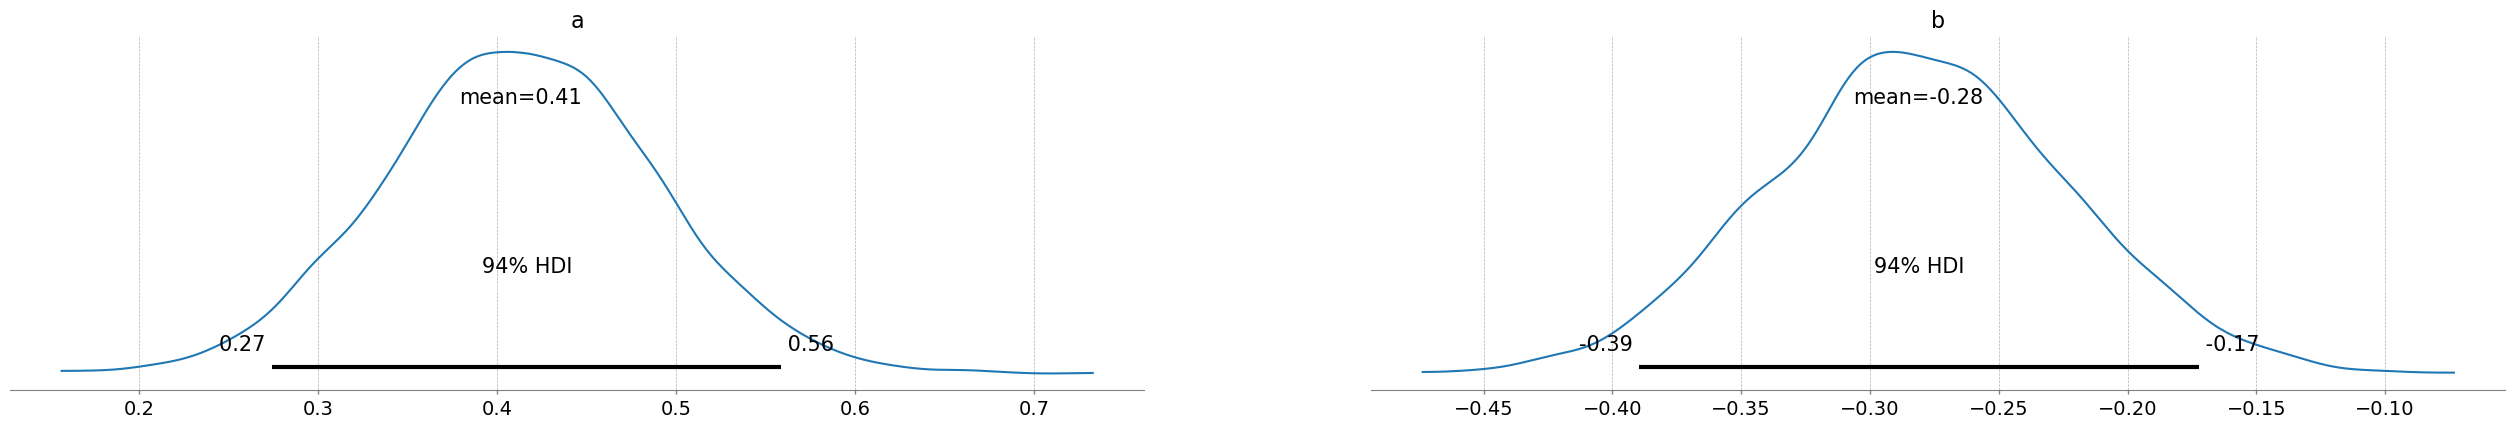

In [12]:
az.plot_posterior(samuelson_trace, var_names=['a', 'b'])

## Stability and the State Space Representation

Unlike the AR(1) model, it's not immediately obvious what values of $\phi_1$ and $\phi_2$ imply stationary model dynamics. An "easy" way to understand stationarity of higher order linear models is to cast them into a linear state space representation.

A linear state space is a recursive matrix equation that describes the evolution of our system. The "system" should be a vector of variables at time $t$ that gives us everything we need to know about the state of the system. In the case of the Samuelson system, that vector is:

$$x = \begin{bmatrix} Y_{t-1} \\ Y_{t-2} \end{bmatrix}$$

Now we just need a "transition matrix" that encodes the equation $Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2}$. With some thinking, you'll find the transition matrix is:

$$ T = \begin{bmatrix} \phi_1 & \phi_2 \\ 1 & 0 \end{bmatrix}$$, so that:

$$\begin{bmatrix} Y_{t} \\ Y_{t-1} \end{bmatrix} = \begin{bmatrix} \phi_1 & \phi_2 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} Y_{t-1} \\ Y_{t-2} \end{bmatrix} + \begin{bmatrix} \phi_0 \\ 0 \end{bmatrix}$$

There are a few more elements: we distinguish between random states and non-random states using a "selection matrix" R, and between observed and unobserved variables using a "design matrix" Z. These aren't important now, but the final linear state space will be:

$$\begin{align} x_{t+1} &= Tx_t + d + R\epsilon_t, & \epsilon_t &\sim N(0, Q) \\
                y_t &= Zx_t + c + \eta_t, & \eta_t & \sim N(0, H) \end{align}$$
                
(for the curious, in our case, $R = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$, $Z = \begin{bmatrix} 1 &  0\end{bmatrix}$, $Q = \sigma^2$, and $H = 0$)

Why is this interesting? For one, it gives a convenient representation for doing forecasting: we just need to draw values of the parameters, assemble T, Q, and H, then iterate.

For another, it makes studying the stability of the system easy. In particular, _the system will be stable when all eigenvalues of T lie within the unit circle in the complex plane_.

In [13]:
params = samuelson_trace.posterior.phi.stack(sample=['chain', 'draw']).sel(phi_dim_0=[1,2]).values.T
params = np.ascontiguousarray(params)

Clearly, the entire posterior in this case is stable. In addition, the eigenvalues for all posterior transition matrices are all strictly real. The size of the imaginary component of the eigenvalue will control how much the solution oscellates as it returns to equlibrium. In our case, we will see smooth re-convergence to the "steady state" after a shock.

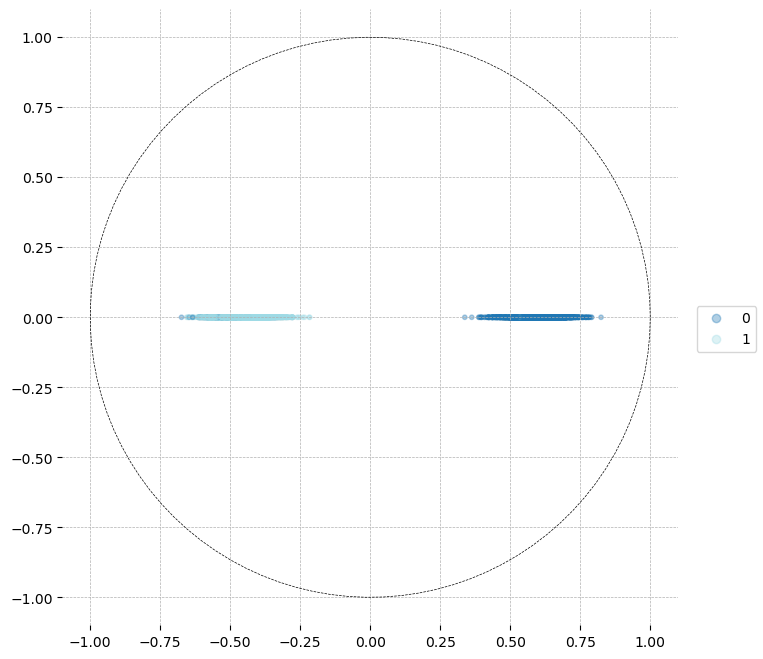

In [14]:
eigs = stability_analysis(np.expand_dims(params, axis=[1,-1]))
plot_eigenvalues(eigs, include_kde=False)

In the AR(2) case, we can also plot stability in parameter space, without resorting to analysis of the eigenvalues. A closed-form solution for the stable region in terms of $\phi_1$ and $\phi_2$ is available. It turns out to be a simplex in parameter space. Here I use code from the QuantEcon lecture to show where our parameters are in the stable simplex.

This is somewhat dissapointing; Samuelson wrote this accelerator model specifically to obtain damped oscillations, and thus business cycle effects. We did not find evidence for these types of business cycles in our estimates.

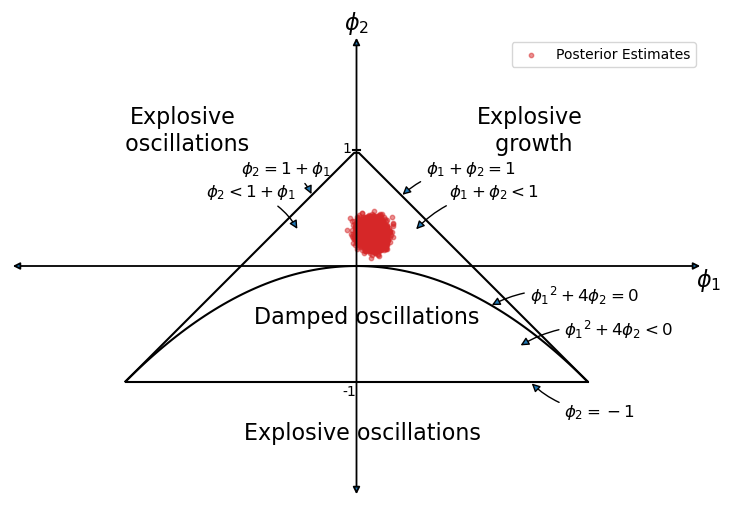

In [15]:
fig, ax = quantecon_param_plot()
ax.scatter(params[:, 0], params[:, 1], s=10, alpha=0.5, color='tab:red', label='Posterior Estimates')
ax.legend()
plt.show()

## How does it forecast?

We can make forecasts using the linear state space model by iterating from a chosen point in the data.

In [16]:
from VAR_to_statespace import make_statespace, simulate

In [17]:
x0 = gdp_diff.iloc[-2:].values
sigmas = samuelson_trace.posterior.sigma.stack(sample = ['chain', 'draw']).values[:, None]
intercepts = samuelson_trace.posterior.stack(sample = ['chain', 'draw']).phi.sel(phi_dim_0=[0]).values.T
sigmas = np.ascontiguousarray((sigmas))

In [18]:
n_samples, n_obs, n_lags, _ = np.expand_dims(params, axis=[1,-1]).shape

In [19]:
samuelson_forecast = statespace_forecast(x0,
                                         coefs=np.expand_dims(params, axis=[1,-1]), 
                                         intercepts=intercepts, 
                                         sigmas=sigmas, 
                                         sigmas_are_chol=False)

As we move through this bloated notebook, we will find repeatedly that autoregressive models have mean-reversion tendency, especially at long forecast horizons. After just 2 periods, there is no data left to forecast on, so the model will smoothly revert to the long-term mean, which in this case is 0.

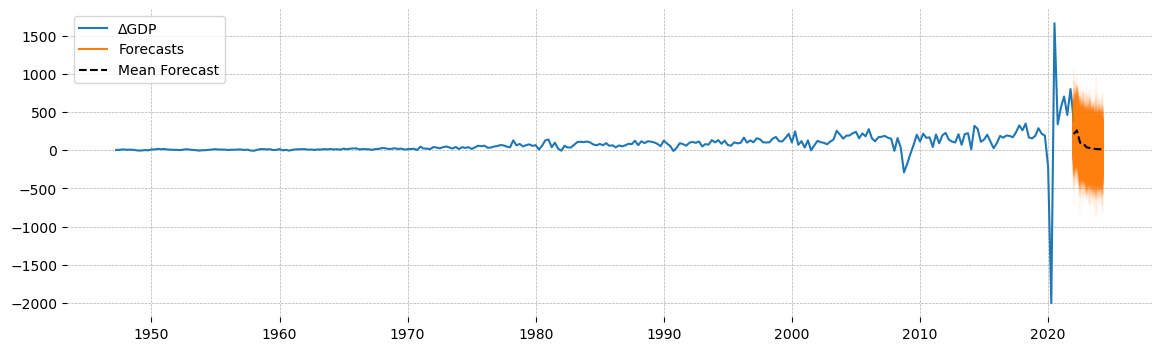

In [20]:
fig, ax = plt.subplots()
forecast_x = pd.date_range(start=gdp.index[-1], periods=samuelson_forecast.shape[1], freq=gdp.index.inferred_freq)
ax.plot(gdp.diff().dropna().index, gdp.diff().dropna(), label='ΔGDP')
ax.plot(forecast_x, samuelson_forecast.squeeze().T, color='tab:orange', alpha=0.05)
ax.plot([], color='tab:orange', label='Forecasts')
ax.plot(forecast_x, samuelson_forecast.squeeze().mean(axis=0), color='k', ls='--', label='Mean Forecast')
ax.legend()
plt.show()

# On to VAR models

A VAR model is just a generalization of everythign we've covered up to this point. We can represent the VAR using the linear state space, check for stability, and all the rest. 

Since there are more than one time series, the dynamics are much more intersting. We can ask questions like, "what would happen to the inflation rate if there were a shock to interest rates", to choose something relevant at the time of writing.

## VAR models as a linear state space

Suppose we have two time series that we suspect are connected -- each determines the other, and they are also connected to their own past. We model it as an autoregressive process, but each time series is also a function of the other. If we think 2 lags are relevant, we can write:

$$\begin{align}y_{1,t} &= \phi_{1,1,1} y_{1,t-1} + \phi_{1,1,2} y_{1, t-2} + \phi_{1,2,1} y_{2,t-1} + \phi_{1,2,2} y_{2, t-2} + \epsilon_{1,t} \\
               y_{2,t} &= \phi_{2,1,1} y_{1,t-1} + \phi_{2,1,2} y_{1, t-2} + \phi_{2,2,1} y_{2,t-1} + \phi_{2,2,2} y_{2, t-2} + \epsilon_{2,t} \end{align}$$
               
This is a very natural candidate for a state-space formulation. If we call $n$ the number of equations and $p$ the number of lags, there will be n * p states: one per lag per state. For example, we re-write the above equations as:

$$\begin{bmatrix} y_{1,t} \\ y_{2,t} \\ y_{1,t-1} \\y_{2,t-1} \end{bmatrix} = \begin{bmatrix} \phi_{1,1,1} & \phi_{1,2,1} & \phi_{1,1,2} & \phi_{1,2,2} \\
                                                                                              \phi_{2,1,1} & \phi_{2,2,1} & \phi_{2,1,2} & \phi_{2,2,2} \\
                                                                                                1 & 0 & 0 & 0 \\
                                                                                                0 & 1 & 0 & 0 \end{bmatrix} 
    \begin{bmatrix} y_{1,t-1} \\ y_{2,t-1} \\ y_{1,t-2} \\y_{2,t-2} \end{bmatrix} + 
    \begin{bmatrix} 1 & 0 \\
                    0 & 1 \\
                    0 & 0 \\
                    0 & 0 \end{bmatrix} \begin{bmatrix} \epsilon_{1,t} \\ \epsilon_{2,t}\end{bmatrix}$$
                    
                    
Once again, this gives a conventient way to iterate out forecasts, check stability, and perform impulse response functions.

## VAR models as a 2d convolution

Before we begin, I want to quickly cover 2d convolution, because this is how I will implement the VAR in PyMC. The prime motivation for doing this is to avoid loops. Typically it is used to process images. The principal behind convolution is that "data that are close together are similar." Sound familiar?

No discussion of convolution can go without an animated GIF showing the process, so I've prepared two. First, consider the AR(2) model. We can put the autoregressive parameters $\phi_1, \phi_2$ into a *kernel* and slide it down the data. Each time we slide the kernel, we will obtain an estimated mean. Here is the GIF:

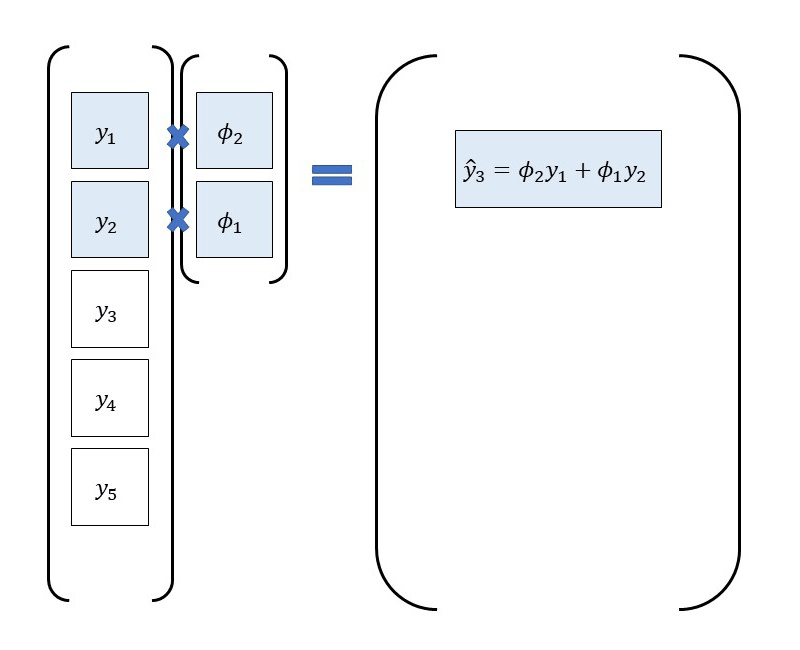

Notice that at each timestep, after running the filter over the data, element-wise multiplying, and summing, we end up with:

$$y_{t} = \phi_1 y_{t-1} + \phi_2 y_{t-2}$$

This is precisely the mean of the AR(2) model we saw above.

The exact same principal applies for a VAR, except now we will use a stack of filters. Since a VAR is just a linear combination of lags from all the time series in the data, we can just fatten the filter to get mean estimates. We also need one filter per equation, since each equation has it's own phi parameters. In total, we will have $n \times n \times p$ parameters, where $n$ is the number of equations and $p$ is the number of lags. 

Each equation will have it's own $n x p$ filter. Here is another GIF, showing how we slide the stack of filters down the data, multiply and sum, and obtain mean estimates for each equation.

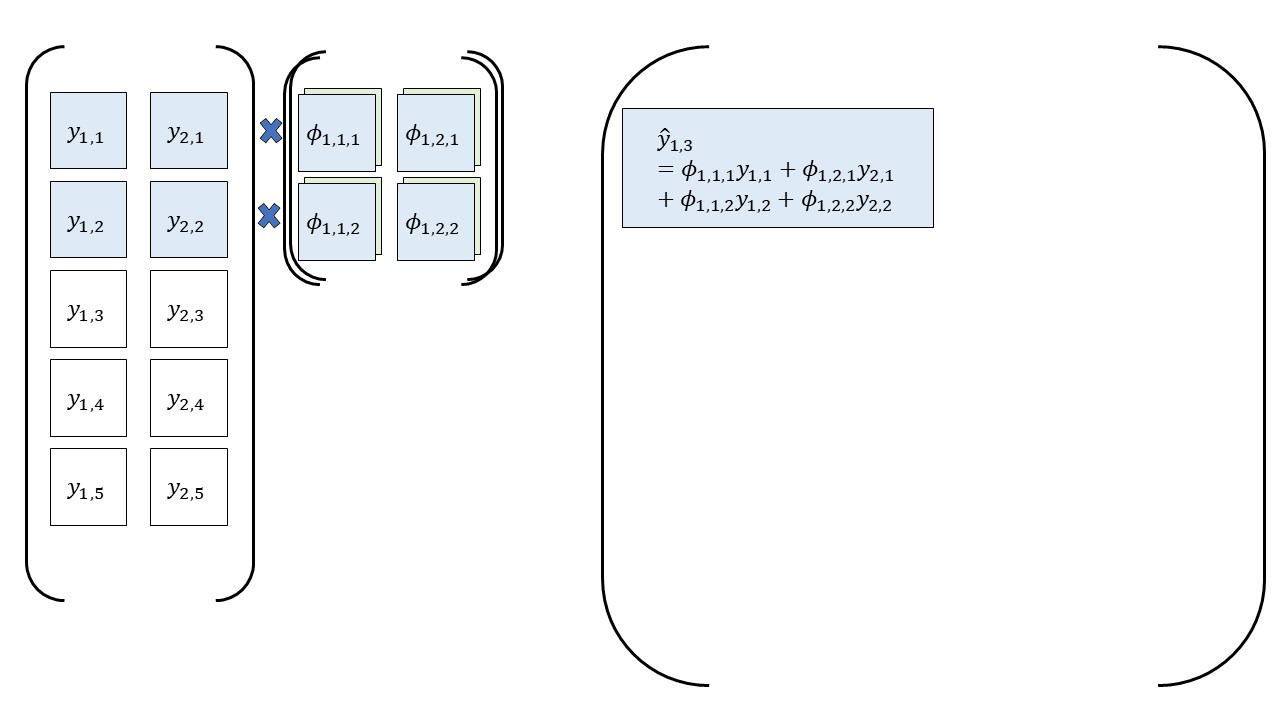

One thing to note: we can't actually use the last output of the convolution, because we don't have data for it. This corresponds to dropping the bottom $p$ rows of our data when we shift it and prepend `nan` to make lagged feature maps "by hand".

In [38]:
import pymc as pm
import pytensor.tensor as pt
from pytensor.tensor.conv import conv2d

def build_VAR(df, n_lags, intercept = True, model_full_cov = True, model_initial_states=True):
    
    start_idx = n_lags * (1 - model_initial_states)
    coords={"lags": np.arange(n_lags) + 1,
            "equations": df.columns.tolist(),
            "vars": df.columns.tolist(),
            "time": [f'{x.year}Q{x.quarter}' for x in df.index[start_idx:]]}
    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=["equations", "lags", "vars"]) #filters x rows x columns
        
        data = pm.ConstantData('data', df.values)
        data_obs = pm.ConstantData('data_obs', df.values[start_idx:], dims=['time', 'equations'])
        
        if model_initial_states:
            x0 = pm.MvNormal('x0', mu=df.mean().values, cov=df.cov().values, dims=['lags', 'vars'])
            data = pm.math.concatenate([x0, data], axis=0)
        
        # Each convolution produces the prediction for time t+1. As a result we have to drop the last row of data,
        # since we don't have an observation that goes with it. For example, the first 4 x 3 block of data makes 
        # a precition for t=5 (4 lags)
        
        # Flip the lags so the first row of the output is the 1st lag, rather than the 4th. This makes
        # switching to the state space representation more convenient.
        VAR_equations = conv2d(input=pt.expand_dims(data[:-1], axis=(0, 1)), # add batch_size = in_filters = 1
                                       filters=pt.expand_dims(lag_coefs, axis=1)[:, :, ::-1, :], # add in_filters = 1
                                       border_mode='valid', 
                                       filter_flip=False)
        
        if intercept:
            intercept = pm.Normal("intercept", mu=0, sigma=1, dims=["equations"])
            mean = intercept + VAR_equations[0, :, :, 0].T
        else:
            mean = VAR_equations[0, :, :, 0].T
        
        if model_full_cov:
            n = df.shape[1]
            noise_chol, _, _ = pm.LKJCholeskyCov('noise_chol', eta=1.0, n=n, sd_dist=pm.HalfNormal.dist(sigma=1.0))
            obs = pm.MvNormal("obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"])
        else:
            sigma = pm.HalfNormal('noise', sigma=1.0, dims=['equations'])
            obs = pm.Normal('obs', mu=mean, sigma=sigma, observed=data_obs, dims=['time', 'equations'])
            
    return model

## VAR Models

These models come from Koop (2010), by way of Heaps (2020). I am just following Koop's preprocessing and model specification without doing a deep analysis of the choices. We're more interested in how PyMC performs at different sizes of VAR.

## Var3(4)

In [39]:
VAR_3_df = train_df[['GDPGrowth', 'CPI', 'FedFunds']].dropna()
n_lags = 4

VAR_3 = build_VAR(VAR_3_df, n_lags=n_lags, model_full_cov=True, model_initial_states=True)

In [42]:
with VAR_3:
    trace_3 = pm.sample(nuts_sampler='nutpie', cores=8, draws=500)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [lag_coefs, x0, intercept, noise_chol]
INFO:pymc.sampling.mcmc:NUTS: [lag_coefs, x0, intercept, noise_chol]
/home/jesse/mambaforge/envs/econ/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/jesse/mambaforge/envs/econ/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/jesse/mambaforge/envs/econ/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/jesse/mambaforge/envs/econ/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 346 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 500 draw iterations (8_000 + 4_000 draws total) took 346 seconds.


In [43]:
params = trace_3.posterior.stack(sample=['chain', 'draw']).lag_coefs.transpose('sample', ...).values
intercepts = trace_3.posterior.stack(sample=['chain', 'draw']).intercept.transpose('sample', ...).values
sigmas = trace_3.posterior.stack(sample=['chain', 'draw']).noise_chol.transpose('sample', ...).values

x0 = VAR_3_df.iloc[-n_lags:, :][::-1].values.ravel()[:, None]
short_horizon = 10
forecast = statespace_forecast(x0, params, intercepts, sigmas, sigmas_are_chol=True, horizon=short_horizon)

### Forecasts

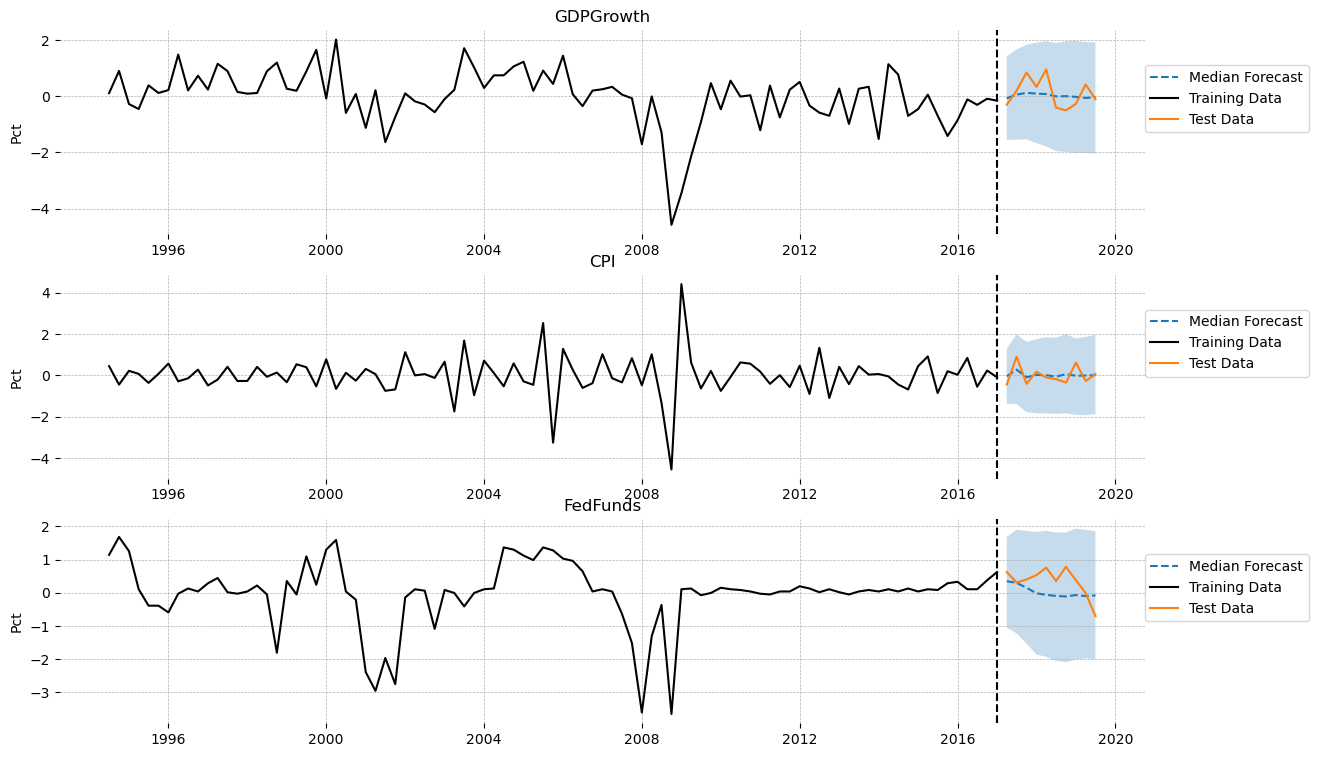

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(14,9))
forcast_index = pd.date_range(start=VAR_3_df.index[-1], periods=forecast.shape[1] + 1, freq='QS')[1:]
q05, q50, q95 = np.quantile(forecast, [0.05, 0.5, 0.95], axis=0)

for i, (axis, variable) in enumerate(zip(fig.axes, VAR_3_df.columns)): 
    
    axis.plot(forcast_index, q50[:, i], ls='--', label='Median Forecast')
    axis.fill_between(forcast_index, y1=q05[:, i], y2=q95[:, i], alpha=0.25)
    
    axis.plot(VAR_3_df.index, VAR_3_df[variable], color='k', label='Training Data')
    axis.plot(test_df.index[:short_horizon], test_df[VAR_3_df.columns].iloc[:short_horizon, i], label='Test Data')
    axis.set_ylabel("Pct", fontsize=10)
    axis.set_title(variable)
    axis.axvline(VAR_3_df.index[-1], ls="--", color="k")
    axis.legend(loc=(1, 0.5), fontsize=10)

### Impulse Response Functions

As promised, we can ask more interesting questions using a VAR than we could using only an AR(2) model. For example, if there is a shock to the interest rate, i.e. the Fed raises interest rates, what happens to inflation (i.e. the price level, CPI)? We canswer this using an impulse response function. We apply a shock to one of the time series, and observe the resulting evolution of the system.

If our model is to be believed, an one-sigma increase in interest rates will spur economic growth at the cost of increased prices (more inflation). Maybe. The 95% CI is really fat. Looks like 0 just barely exits the GDP's CI, while CPI is centered on 0 the entire time. If the Fed is running a model like this, they might be tempted to roll the dice!

In [46]:
irf_4 = bayesian_impulse_response_function(params)

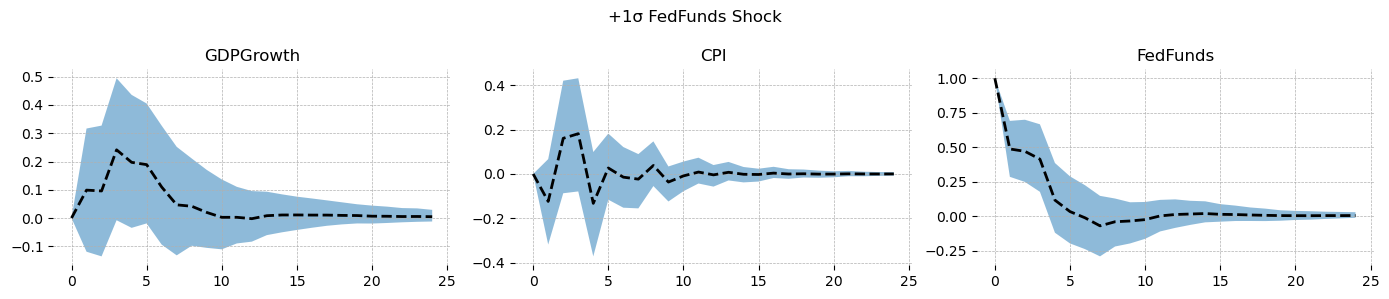

In [47]:
sim_length = 25
variable = 'FedFunds'
fig, ax = plt.subplots(1, 3, figsize=(14,3))

title = f'+1σ {variable} Shock'
shock_size = VAR_3_df[variable].std()
irf = bayesian_impulse_response_function(params, sim_length=sim_length, shock_state=2, shock_size=1)
q05, q50, q95 = np.quantile(irf, [0.05, 0.5, 0.95], axis=0)    

for j, axis in enumerate(fig.axes):
    axis.plot(irf[:, :, j].mean(axis=0), color='k', ls='--', lw=2)
    axis.fill_between(np.arange(sim_length), q05[:, j], q95[:, j], alpha=0.5)
    axis.set_title(VAR_3_df.columns[j])
fig.suptitle(title)
fig.tight_layout()
plt.show()

Unlike the simple AR(2) model we saw above, these time series are not smoothly returning to the steady state. CPI in particular shows a lot of wiggle around 0 as it evolves. This is because the eigenvalues of `T` are complex. Plotting these eigenvalues, we can see they are almost all within the unit circle, so model dynamics are stable. A couple dots are escaping, though. We are getting to the limits of stationarity for a model of this size.

In additon, there are many regions of parameter space that have large imaginary component, inducing these oscillating dynamics we saw particularly in the CPI series. FedFunds also has some gentle oscillation, that is what causes the "overshooting" we observe at periods 6-10, where it dips under 0 then goes back up. 

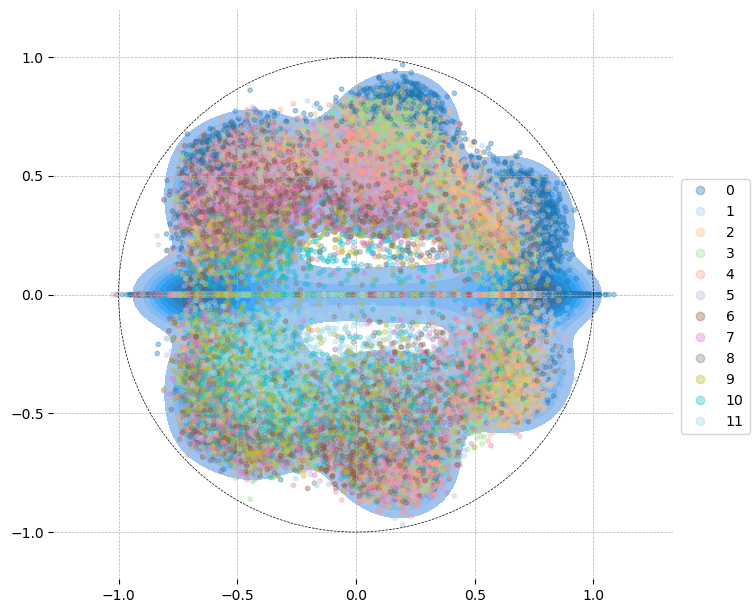

In [48]:
eigs = stability_analysis(params)
plot_eigenvalues(eigs, include_kde=True)

## VAR10

Bigger is better, onward and upward! With 10 variables and 4 lags, we are estimating 500 VAR parameters (10 10x4 filters, plus a 10x10 covaraince matrix). As a result, these models will start taking longer to run, and will need a bit more tuning.

We could bring that number down quite a bit by only modeling the diagonal of the covariance matrix, but I am going to stubbornly press on like this.

Here I up the target_accept to 0.9 and use the new gradient-based initializer to avoid the divergences I got with the defaults.

In [49]:
var10_vars = ['GDPGrowth', 'CPI', 'FedFunds',
             'PPI_All', 'NonBorrowReserves', 'TotalReserves',
              'M2Supply', 'PersonalConsum', 'IndustrialProd',
              'CapacityUtil']
VAR_10_df = train_df[var10_vars].dropna()

n_lags = 4
VAR_10 = build_VAR(VAR_10_df, n_lags=n_lags, model_full_cov=True, model_initial_states=False)

In [52]:
with VAR_10:
    trace_10 = pm.sample(nuts_sampler='nutpie', cores=8, draws=500)

/home/jesse/mambaforge/envs/econ/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AbstractConv2d{convdim=2, border_mode='valid', subsample=(1, 1), filter_flip=False, imshp=(None, None, None, None), kshp=(None, None, None, None), filter_dilation=(1, 1), num_groups=1, unshared=False}'s perform method
  warnings.warn(
/home/jesse/mambaforge/envs/econ/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/jesse/mambaforge/envs/econ/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/jesse/mambaforge/envs/econ/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AbstractConv2d_gradWeights{convdim=2, border_mo

In [61]:
params = trace_10.posterior.stack(sample=['chain', 'draw']).lag_coefs.transpose('sample', ...).values
params = np.ascontiguousarray(params)
intercepts = trace_10.posterior.stack(sample=['chain', 'draw']).intercept.transpose('sample', ...).values
sigmas = trace_10.posterior.stack(sample=['chain', 'draw']).noise_chol.transpose('sample', ...).values

x0 = VAR_10_df.iloc[-n_lags:, :][::-1].values.ravel()[:, None]

Now we're really at the limits of stationarity. We can see a large mass of samples are now clustering outside the unit circle. Model dynamics are going to blow up.

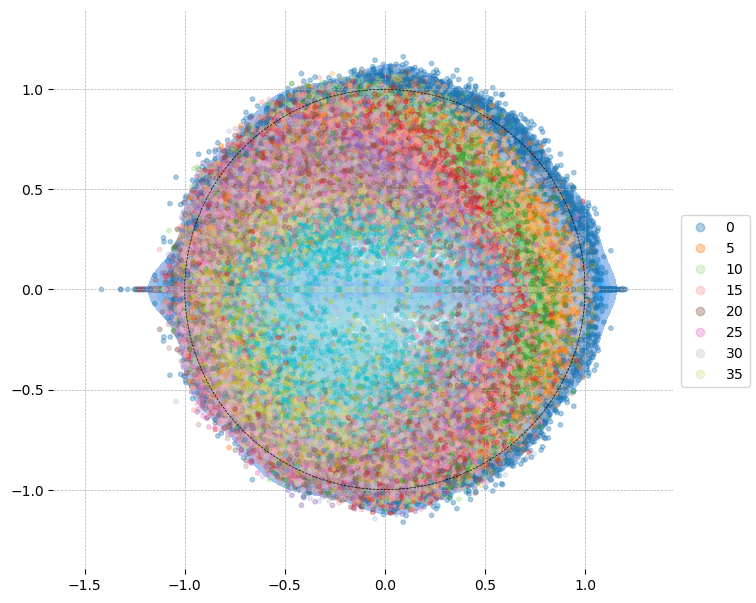

In [59]:
eigs = stability_analysis(params)
plot_eigenvalues(eigs, include_kde=True)

We can see all the different blow-up modes by skimming over all 100 impulse response functions. As suggested by the QuantEcon plot above, there are four modes:

Good endings:

1. Smooth convergence
2. Dampened oscillations 

Bad endings:

3. Exponential blowup
4. Oscillating blowup

We can see all of them represented below. Essentially no dynamics are stable.

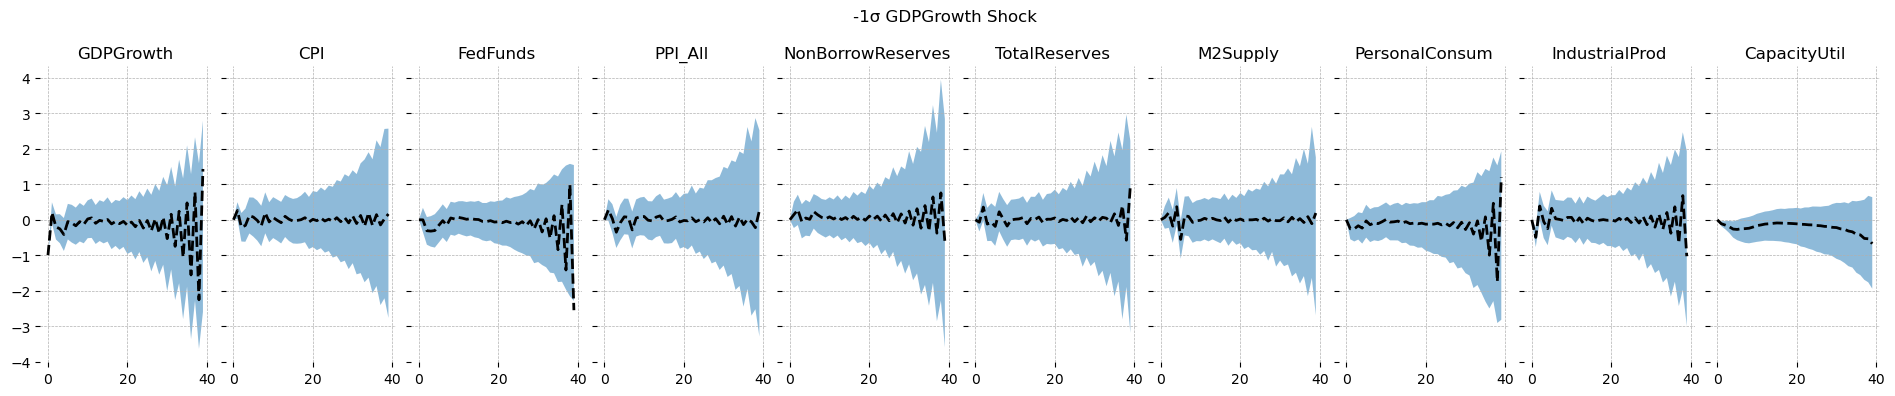

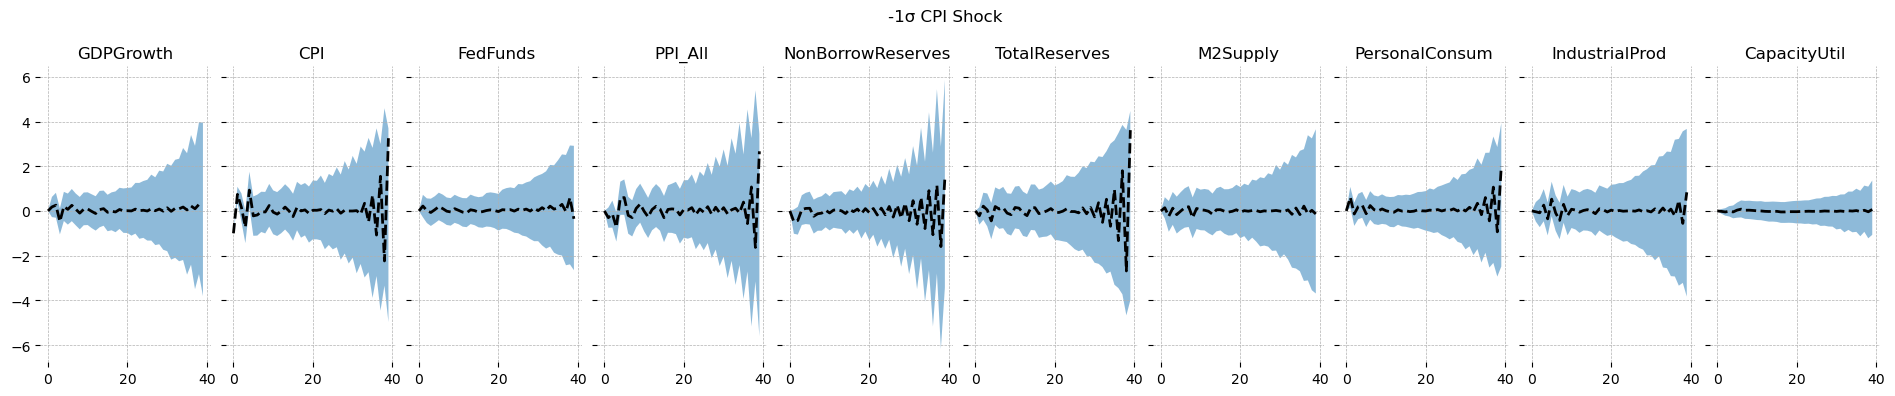

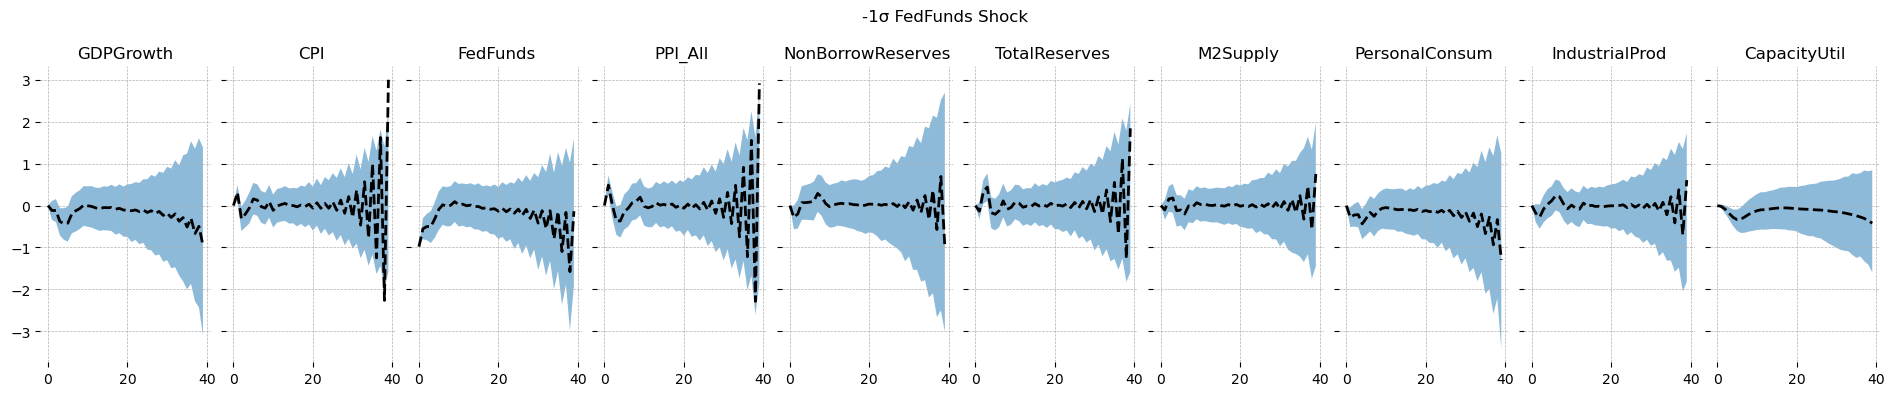

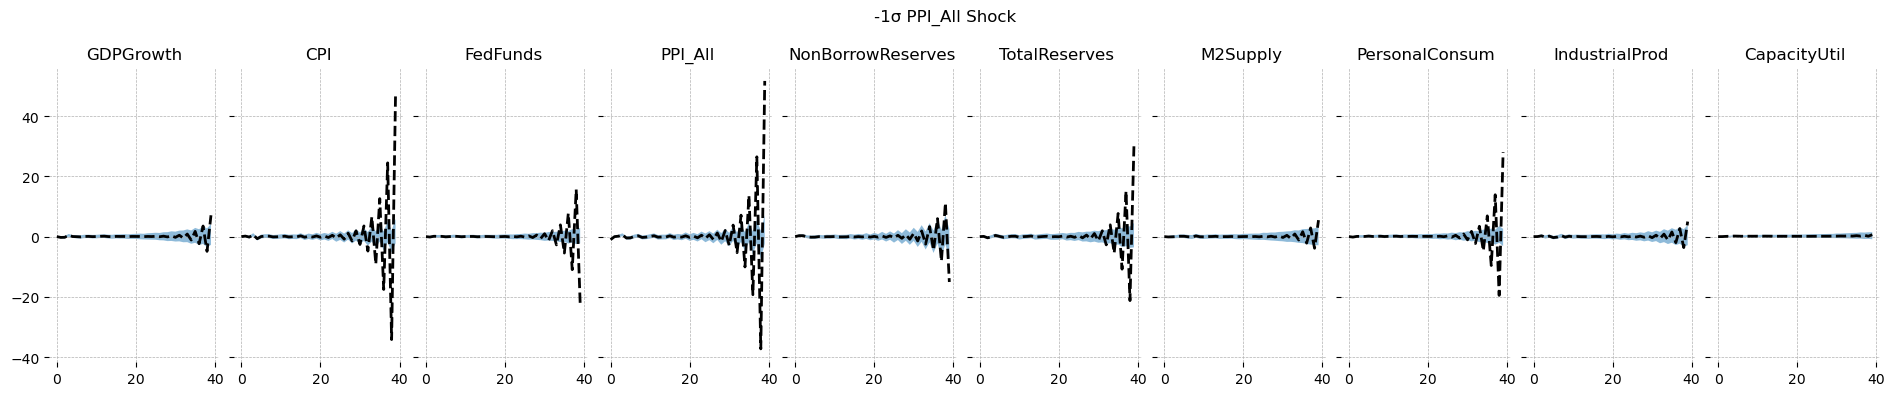

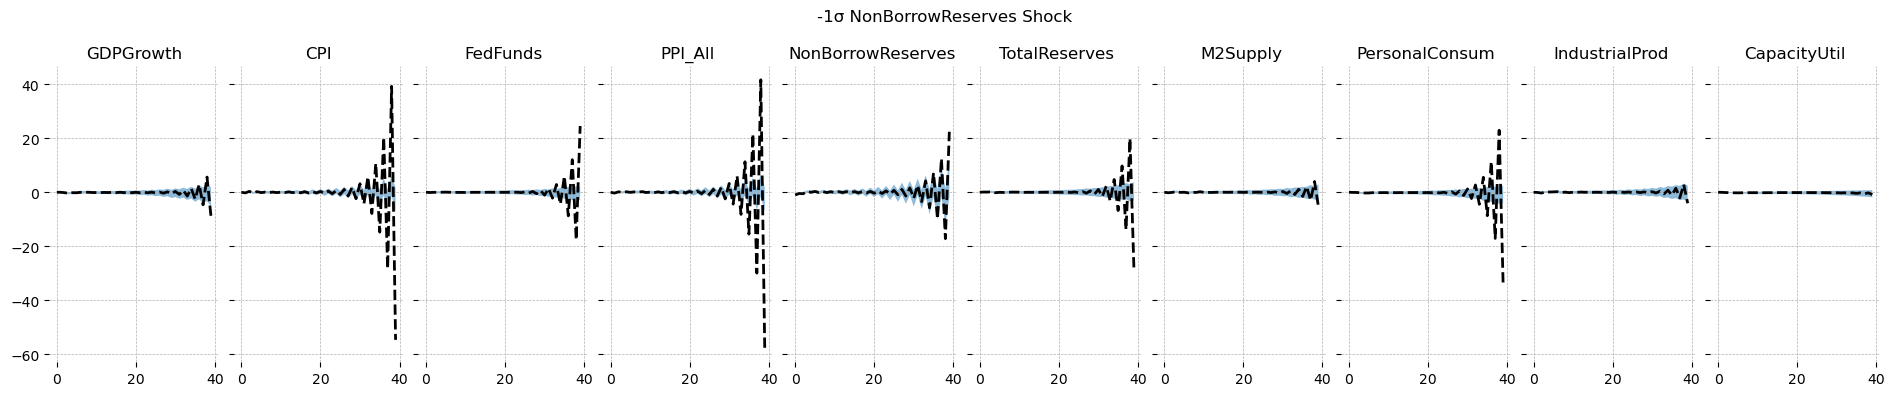

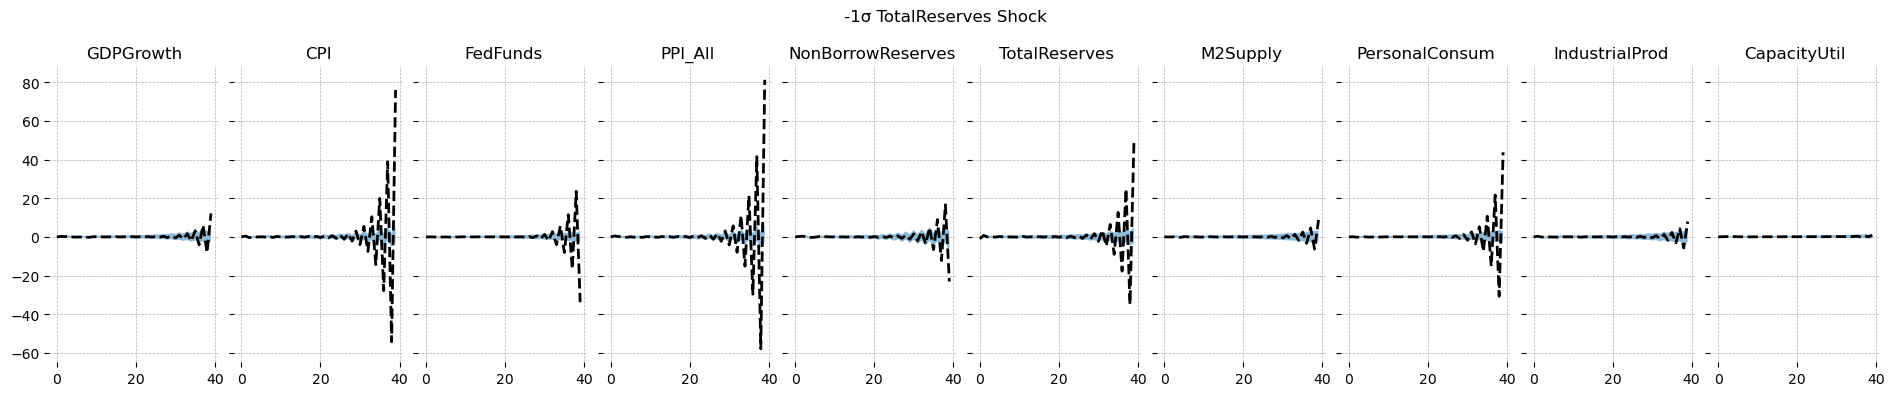

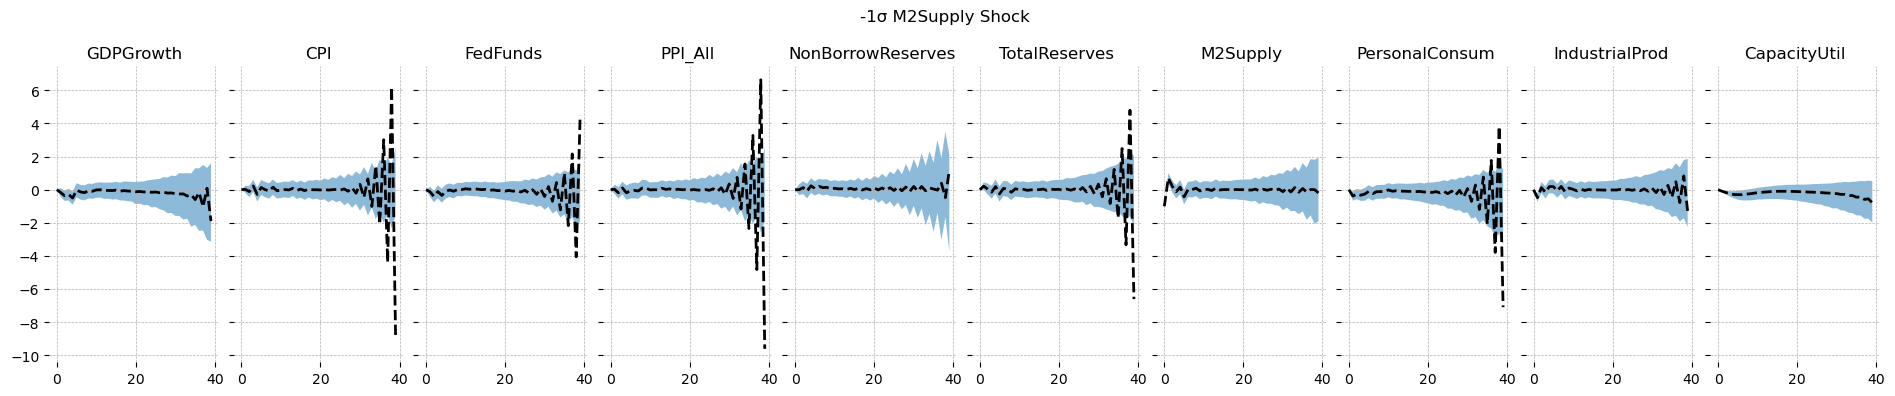

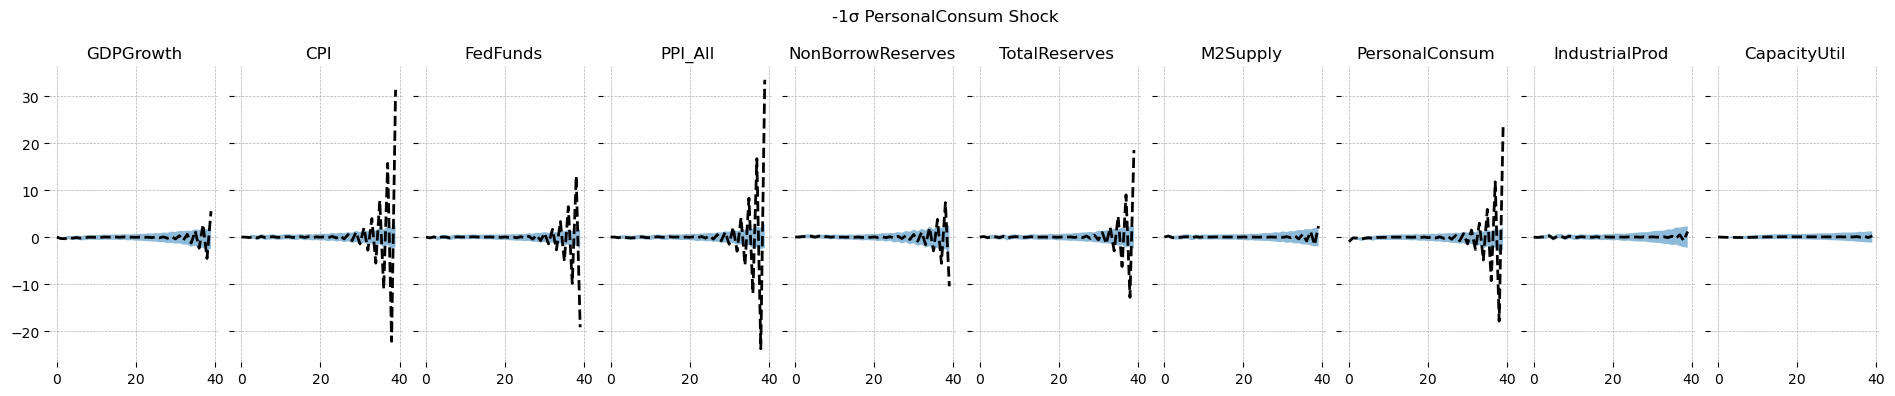

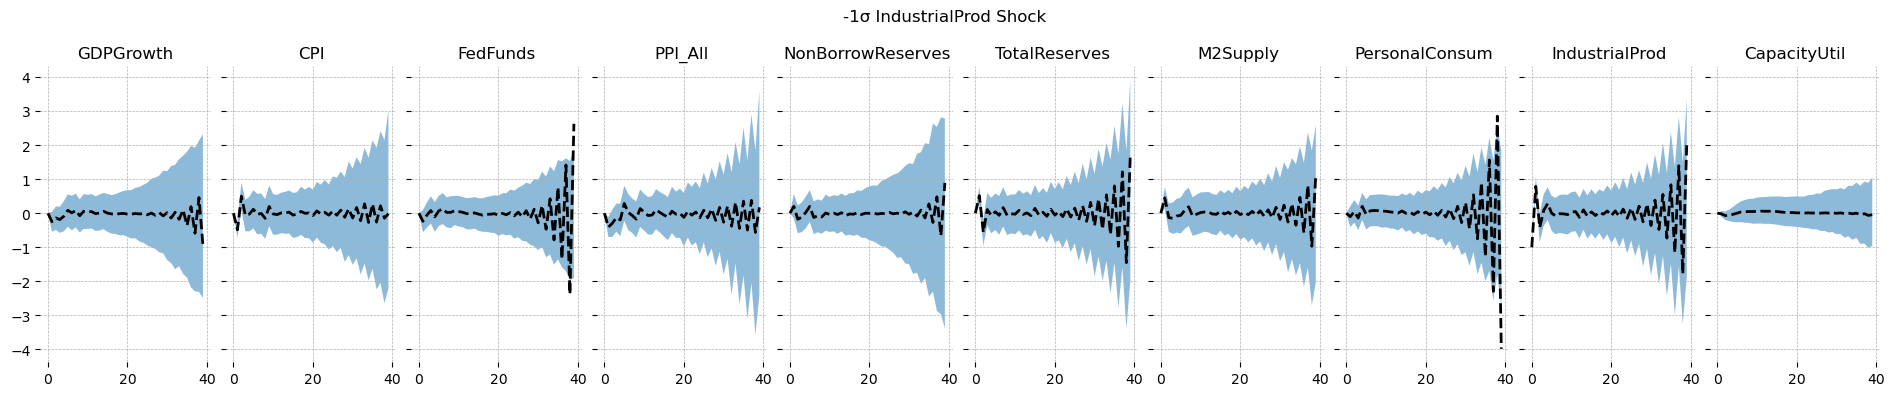

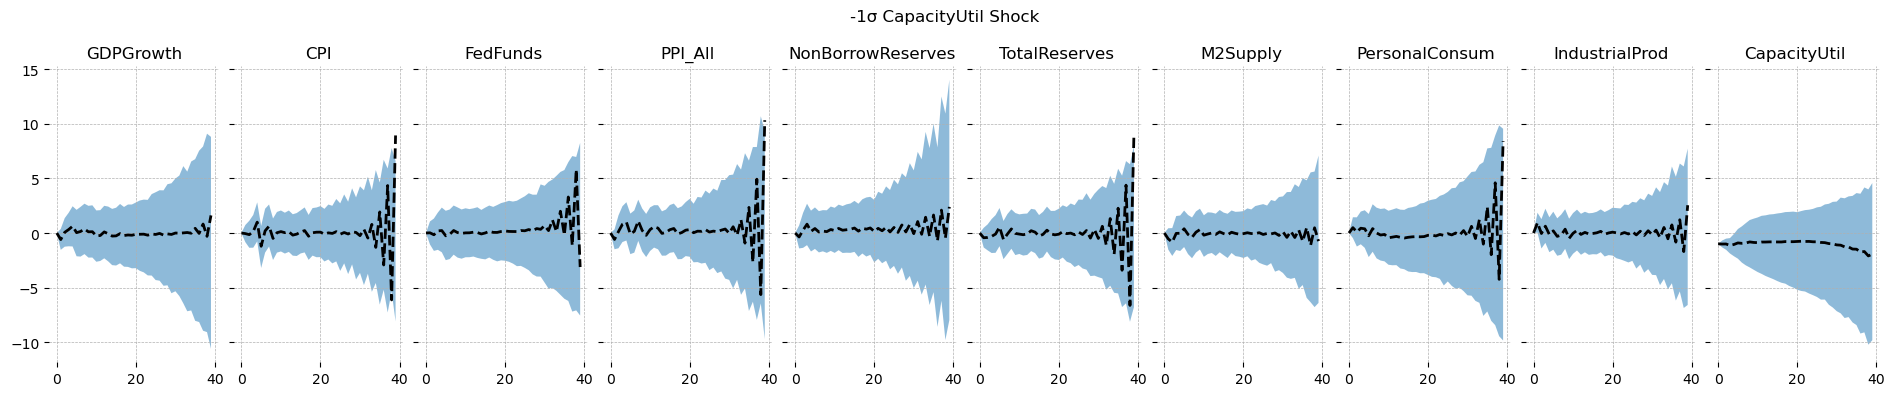

In [62]:
sim_length = 40
n = 10
for i, variable in enumerate(VAR_10_df.columns):
    fig, ax = plt.subplots(1, 10, figsize=(19,4), sharey=True)

    title = f'-1σ {variable} Shock'
    shock_size = VAR_10_df[variable].std()
    irf = bayesian_impulse_response_function(params, sim_length=sim_length, shock_state=i, shock_size=-shock_size)
    q05, q50, q95 = np.quantile(irf, [0.05, 0.5, 0.95], axis=0)    
    
    for j, axis in enumerate(fig.axes):
        axis.plot(irf[:, :, j].mean(axis=0), color='k', ls='--', lw=2)
        axis.fill_between(np.arange(sim_length), q05[:, j], q95[:, j], alpha=0.5)
        axis.set_title(VAR_10_df.columns[j])
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

### Does stability matter for forecasting?

Well, yes and no. Let's do some short (4 period -- 1 year) and medium (10 period, 2.5 year) forcasts for GDP growth.

#### 1 Year Forecasts

The forecasts look much better, except for CPI, which is bouncing up and down. GDP and interest rates are basically spot on.

/tmp/ipykernel_244654/833099031.py:3: FutureWarning: 'Qs' is deprecated and will be removed in a future version, please use 'QS' instead.
  forcast_index = pd.date_range(start=VAR_10_df.index[-1], periods=forecast.shape[1] + 1, freq='Qs')[1:]


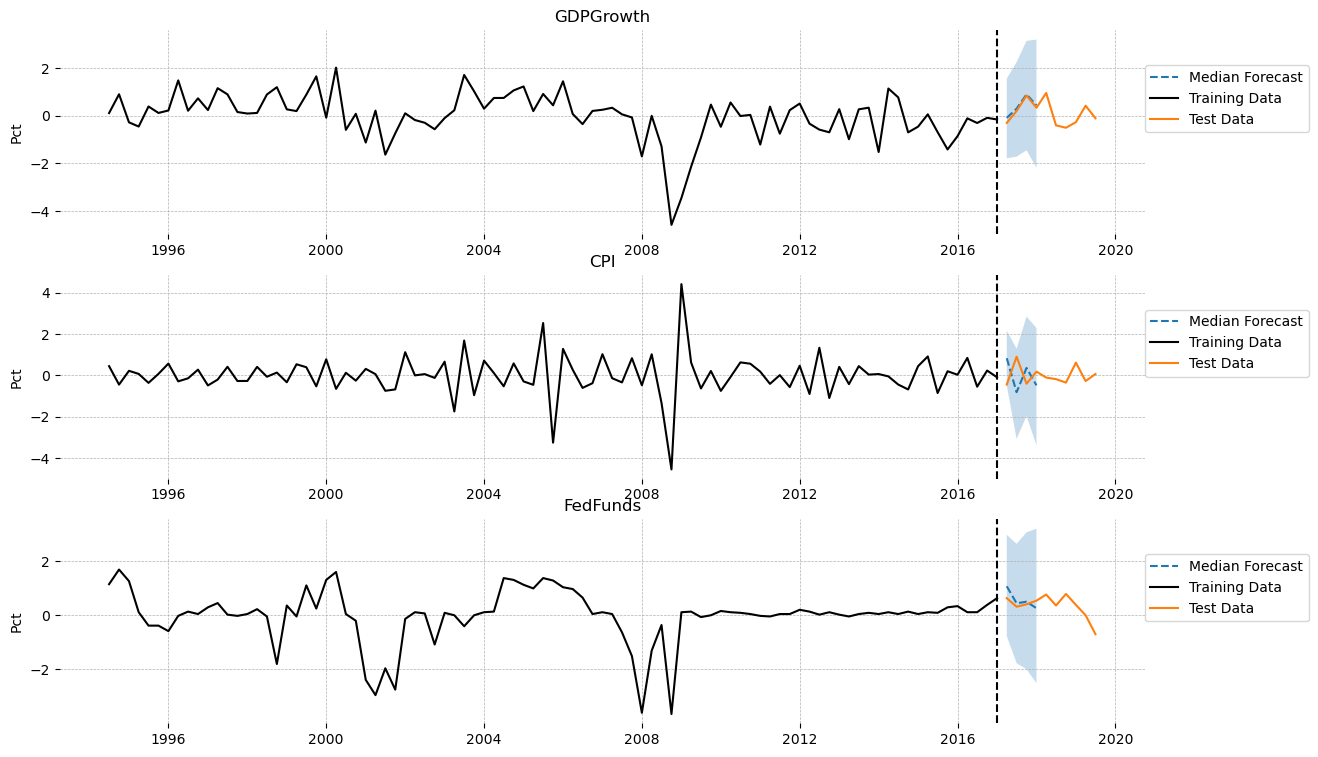

In [63]:
fig, ax = plt.subplots(3, 1, figsize=(14,9))
forecast = statespace_forecast(x0, params, intercepts, sigmas, sigmas_are_chol=True, horizon=4)
forcast_index = pd.date_range(start=VAR_10_df.index[-1], periods=forecast.shape[1] + 1, freq='Qs')[1:]
q05, q50, q95 = np.quantile(forecast, [0.05, 0.5, 0.95], axis=0)

for i, (axis, variable) in enumerate(zip(fig.axes, VAR_10_df.columns)): 
    
    axis.plot(forcast_index, q50[:, i], ls='--', label='Median Forecast')
    axis.fill_between(forcast_index, y1=q05[:, i], y2=q95[:, i], alpha=0.25)
    
    axis.plot(VAR_10_df.index, VAR_10_df[variable], color='k', label='Training Data')
    axis.plot(test_df.index[:short_horizon], test_df[VAR_10_df.columns].iloc[:short_horizon, i], label='Test Data')
    axis.set_ylabel("Pct", fontsize=10)
    axis.set_title(variable)
    axis.axvline(VAR_10_df.index[-1], ls="--", color="k")
    axis.legend(loc=(1, 0.5), fontsize=10)

#### 2.5 year forecasts

These still look good!

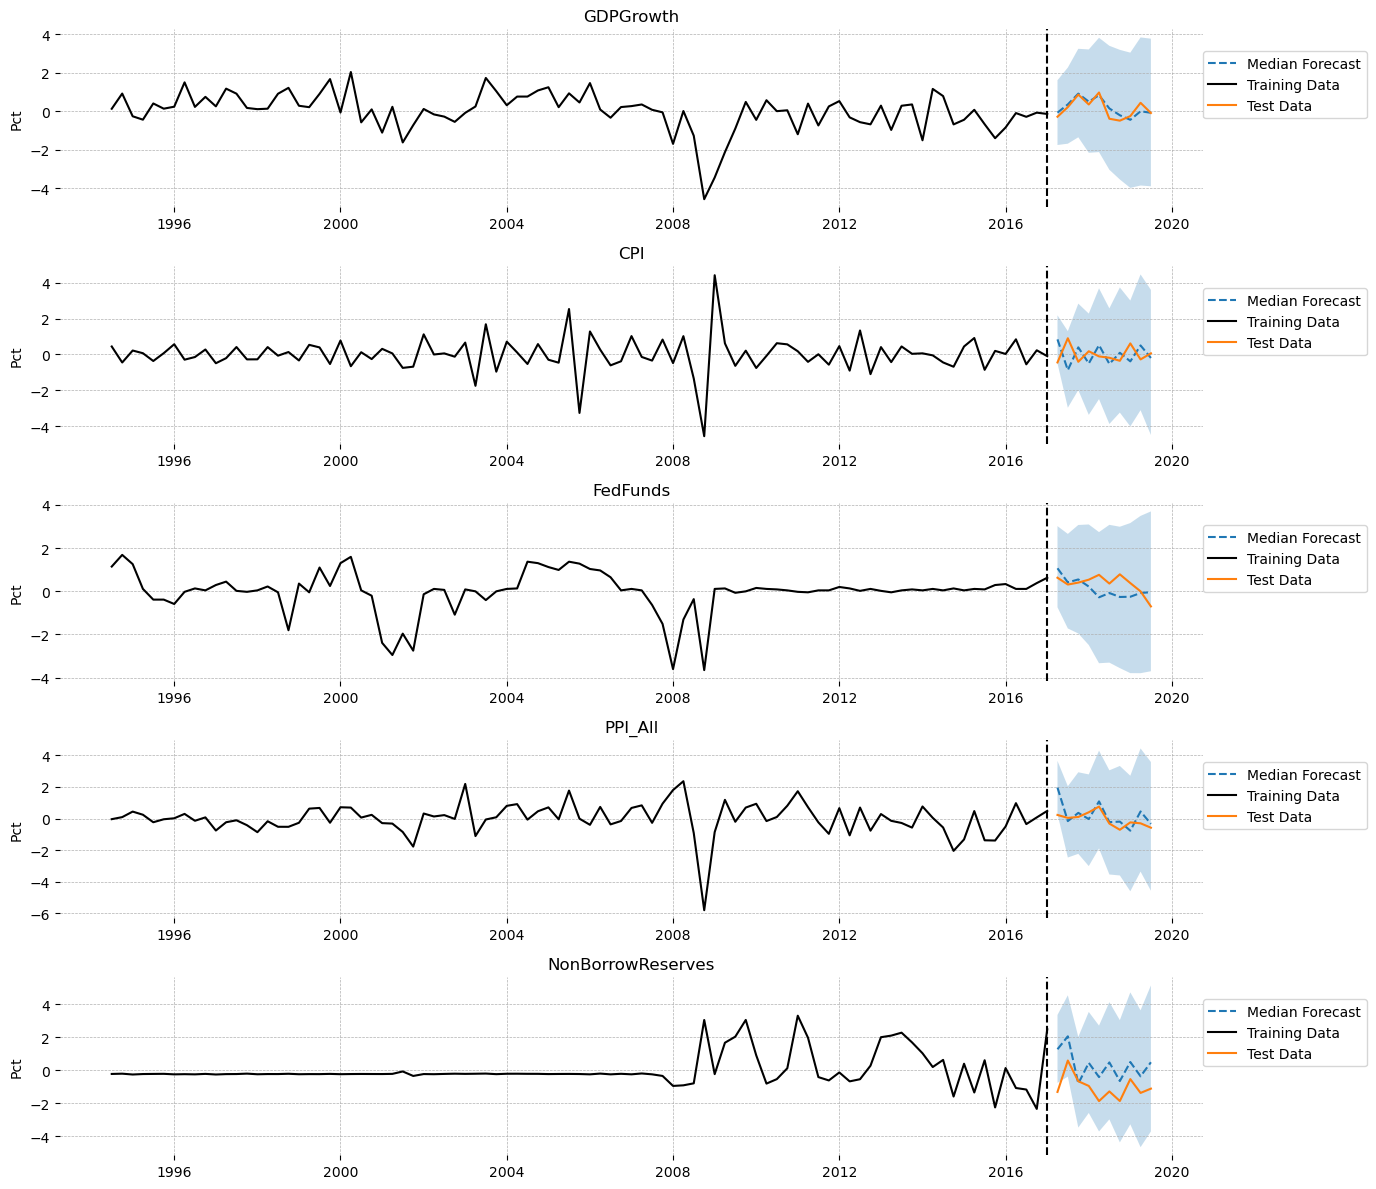

In [65]:
fig, ax = plt.subplots(5, 1, figsize=(14,12))
forecast = statespace_forecast(x0, params, intercepts, sigmas, sigmas_are_chol=True, horizon=10)
forcast_index = pd.date_range(start=VAR_10_df.index[-1], periods=forecast.shape[1] + 1, freq='QS')[1:]
q05, q50, q95 = np.quantile(forecast, [0.05, 0.5, 0.95], axis=0)

for i, (axis, variable) in enumerate(zip(fig.axes, VAR_10_df.columns)): 
    
    axis.plot(forcast_index, q50[:, i], ls='--', label='Median Forecast')
    axis.fill_between(forcast_index, y1=q05[:, i], y2=q95[:, i], alpha=0.25)
    
    axis.plot(VAR_10_df.index, VAR_10_df[variable], color='k', label='Training Data')
    axis.plot(test_df.index[:short_horizon], test_df[VAR_10_df.columns].iloc[:short_horizon, i], label='Test Data')
    axis.set_ylabel("Pct", fontsize=10)
    axis.set_title(variable)
    axis.axvline(VAR_10_df.index[-1], ls="--", color="k")
    axis.legend(loc=(1, 0.5), fontsize=10)
fig.tight_layout()
plt.show()

# VAR 32

Onward and upward! Bigger is better! 

In [75]:
VAR_32 = build_VAR(train_df.dropna(), n_lags=4, model_full_cov=True, model_initial_states=False)
with VAR_32:
    trace_32 = pm.sample(init='advi+adapt_diag', cores=8, draws=500, target_accept=0.99)

Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 11,785
INFO:pymc.variational.inference:Finished [100%]: Average Loss = 11,785
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [lag_coefs, intercept, noise_chol]
INFO:pymc.sampling.mcmc:NUTS: [lag_coefs, intercept, noise_chol]
/home/jesse/mambaforge/envs/econ/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/home/jesse/mambaforge/envs/econ/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ValueError: Not enough samples to build a trace.

In [72]:
params = trace_32.posterior.stack(sample=['chain', 'draw']).lag_coefs.transpose('sample', ...).values
params = np.ascontiguousarray(params)
intercepts = trace_32.posterior.stack(sample=['chain', 'draw']).intercept.transpose('sample', ...).values
sigmas = trace_32.posterior.stack(sample=['chain', 'draw']).noise_chol.transpose('sample', ...).values

x0 = train_df.iloc[-n_lags:, :][::-1].values.ravel()[:, None]

YOU HAVE FLOWN TOO HIGH TOO QUICKLY MORTAL, THE EYE OF TERROR TURNS ITS BALEFUL GAZE TOWARDS YOU. RETURN YE TO YOUR HOMELAND, FOR UNFATHOMABLE DEMONS LURK IN THIS IMPENETRABLE DARKNESS

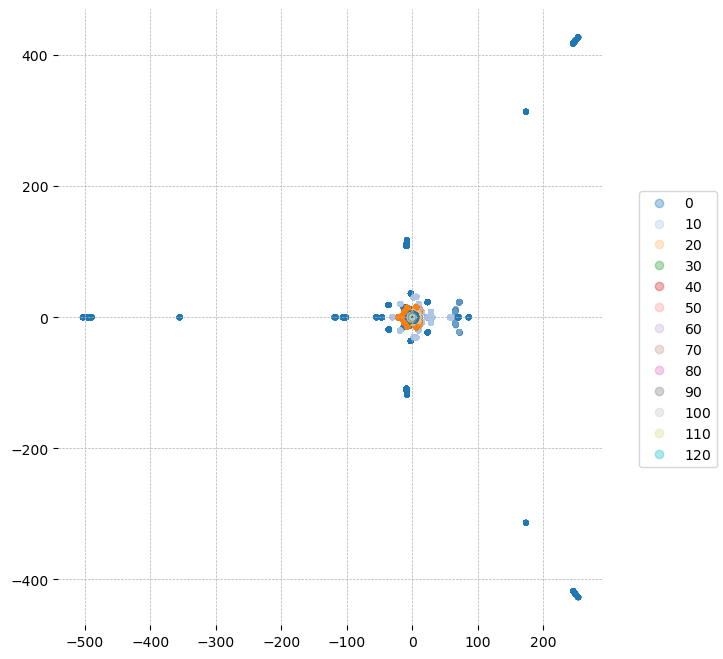

In [73]:
eigs = stability_analysis(params)
plot_eigenvalues(eigs, include_kde=False)

# Restrict the model to stationary VAR using Heaps Prior and Transform

So we reached for the stars and we attracted the Gaze of the Forgotten Gods. It happens. We also got a ton of divergences, and the model fit very slowly. What can we do? We would like to constrain our samples to only come from the stationary region of parameter space. Since we're Bayesian, we do that through choice of priors. In the AR(1) world, we could do that by choosing a prior with support over (-1, 1). In VAR(30, 4) world, it's not obvious how to proceed.

Heaps (2022) provdies one solution, via a reparameterization and transformation. Instead of sampling the VAR filters directly, we will sample transformed autocovariance matrices. It is known from Ansley and Kohn (1986) that there is a 1:1 correspondence between autocovariance matrices and VAR parameters. We can sample these autocovaraince matrices, then transform them into parameter matrices. 

One last issue is that placing a prior directly over the autocovaraince matrices doesn't have any obvious meaning. It's also likely not exchangable -- we might end up using a prior that supposes the order we enter the VAR equations means something. A prior, it does not. So we would like something exchangable and interpertable. Heaps provides such a prior scheme, which I implement below.

In [45]:
n_lags = 2 # Code breaks if n_lags = 1 because it tires to run an empty scan; check with Aesara devs
n_eq = 5
k_offdiag = n_eq * (n_eq - 1)

coords={"lag": np.arange(n_lags) + 1,
        "equation": np.arange(n_eq),
        "var": np.arange(n_eq),
        'position':['diag', 'off-diag'],
        "time": np.arange(10)}

with pm.Model(coords=coords) as heap_model:
    #InvGamma(df / 2, scale / 2) -> InverseWishart(df, scale, p=1) ?
    chol, corr, stds = pm.LKJCholeskyCov('sigma_chol', eta=1.0, sd_dist=pm.HalfNormal.dist(sigma=1.0), n=n_eq)
    Sigma = pm.Deterministic('Sigma', chol.dot(chol.T))
    
    A_mu_1 = pm.Normal('A_mu_1', mu=0, sigma=np.sqrt(0.35), dims=['position', 'lag'])
    A_tau_1 = pm.Gamma('A_tau_1', alpha=1.05, beta=0.0075, dims=['position', 'lag'])
    A_diag_1 = pm.Normal('A_diag_1', mu=A_mu_1[0], tau=A_tau_1[0], dims=['equation', 'lag']).T
    
    # I don't think we can have nice coords for this, it's the unraveled lower-triangular part
    # of a VAR filter
    A_offdiag_1 = pm.Normal('A_offdiag_1', mu=A_mu_1[1], tau=A_tau_1[1], size=(k_offdiag, n_lags)).T
    
    # These are the convolutional filters in R(m x m)
    # We need to organize things so that lags are the "batch dimension", since the reverse-mapping iterates 
    # in the lag dimension
    A_1 = pm.Deterministic('A_1', build_A_matrix(A_diag_1, A_offdiag_1, n_lags, n_eq))
    P_1 = pm.Deterministic('P_1', A_to_P(A_1), dims=['lag', 'equation', 'var'])    
    VAR_params_1 = pm.Deterministic('params_1', P_to_params(P_1, Sigma)[0], dims=['lag', 'equation', 'var'])

    A_mu_2 = pm.Normal('A_mu_2', mu=0, sigma=np.sqrt(3.5), dims=['position', 'lag'])
    A_tau_2 = pm.Gamma('A_tau_2', alpha=10.5, beta=14.25,  dims=['position', 'lag'])
    A_diag_2 = pm.Normal('A_diag_2', mu=A_mu_2[0], tau=A_tau_2[0], dims=['equation', 'lag']).T
    A_offdiag_2 = pm.Normal('A_offdiag_2', mu=A_mu_2[1], tau=A_tau_2[1], size=(k_offdiag, n_lags)).T
    
    A_2 = build_A_matrix(A_diag_2, A_offdiag_2, n_lags, n_eq)
    P_2 = pm.Deterministic('P_2', A_to_P(A_2), dims=['lag', 'equation', 'var'])
    VAR_params_2 = pm.Deterministic('params_2', P_to_params(P_2, Sigma)[0], dims=['lag', 'equation', 'var'])
    
    prior = pm.sample_prior_predictive(var_names=['P_1', 'P_2', 'Sigma', 'params_1', 'params_2'],  samples=10_000)

Sampling: [A_diag_1, A_diag_2, A_mu_1, A_mu_2, A_offdiag_1, A_offdiag_2, A_tau_1, A_tau_2, sigma_chol]


Here I recreate her figure S5, from the supplimentary materials to the paper. It shows the prior distribution over autocorrelation matrices for a VAR(2, 1) model. This prior is heirarchcial: we first draw the diagonal, i.e. the autocorrelation of the time series with itself, then draw the off-diagonal terms, the correlation between the time series. This shows only the pair-plot for lag 1, between equations 1 and 2.

As in figure s5, I plot the prior distribution with two parameterizations: one with a smaller heirarchical variance (orange) and one with a larger variance (blue).

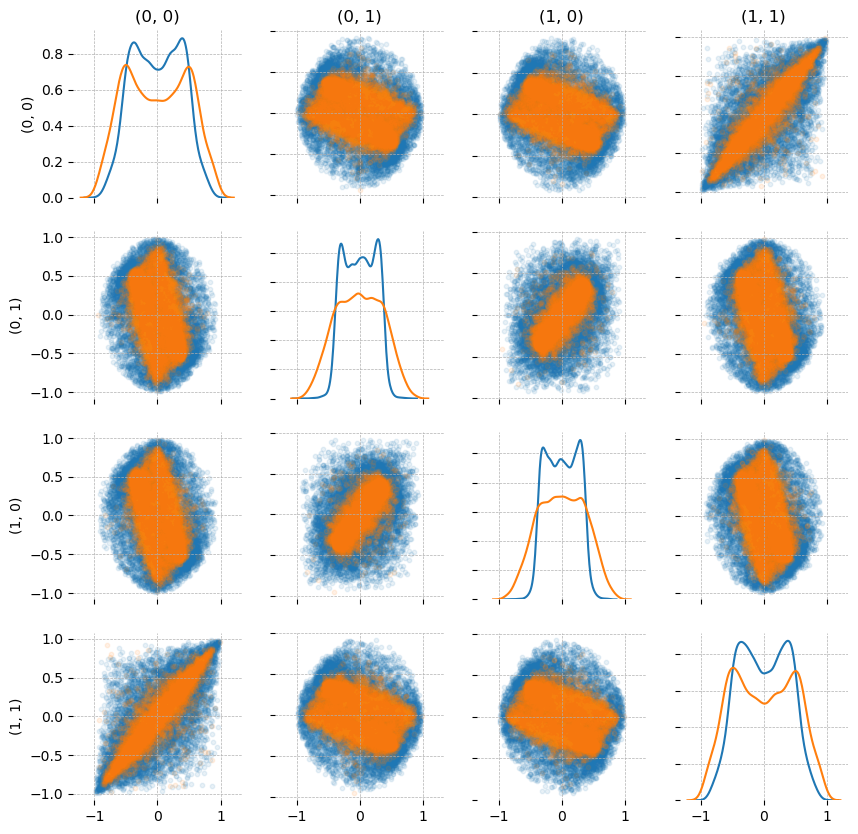

In [46]:
import seaborn as sns
fig, ax = plt.subplots(4, 4, figsize=(10, 10), sharex=True)
P1_samples = prior.prior.P_1.sel(lag=1).values.squeeze()
P2_samples = prior.prior.P_2.sel(lag=1).values.squeeze()
coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i, x in enumerate(coords):
    for j, y in enumerate(coords):
        axis = ax[i][j]        
        if i == j:
            sns.kdeplot(x=P1_samples[:, x[0], x[1]], ax=axis)
            sns.kdeplot(x=P2_samples[:, x[0], x[1]], ax=axis)
            axis.set(ylabel='')
        else:
            axis.scatter(P2_samples[:, x[0], x[1]], P2_samples[:, y[0], y[1]], s=10, alpha=0.1)
            axis.scatter(P1_samples[:, x[0], x[1]], P1_samples[:, y[0], y[1]], s=10, alpha=0.1)
        if i == 0:
            axis.set(title=y)
        if j == 0:
            axis.set(ylabel=x)
        else:
            axis.tick_params(axis='y', labelleft=False)


My implementation does NOT reproduce figure S6. This could be a numerical glitch, since it seems there are some huge parameter values being proposed by the prior. Figure s6 shows that proposals in the Stan implementation are between -10 and 10, which I have clipped the axis to here. The distribution of values is also not the same.

Aside from being a glitch, this could also be a result of a slightly different parameterization. Heaps used an inverse wishart distribution to model the covariance matrix, whereas I am using an LKJCholesky distribution. I am not familiar enough with the mathematical ins and outs of the problem to know whether this could be the source of the problem.

Nevertheless, the majority of the prior probabilty mass is located between -10 and 10, as it should be.

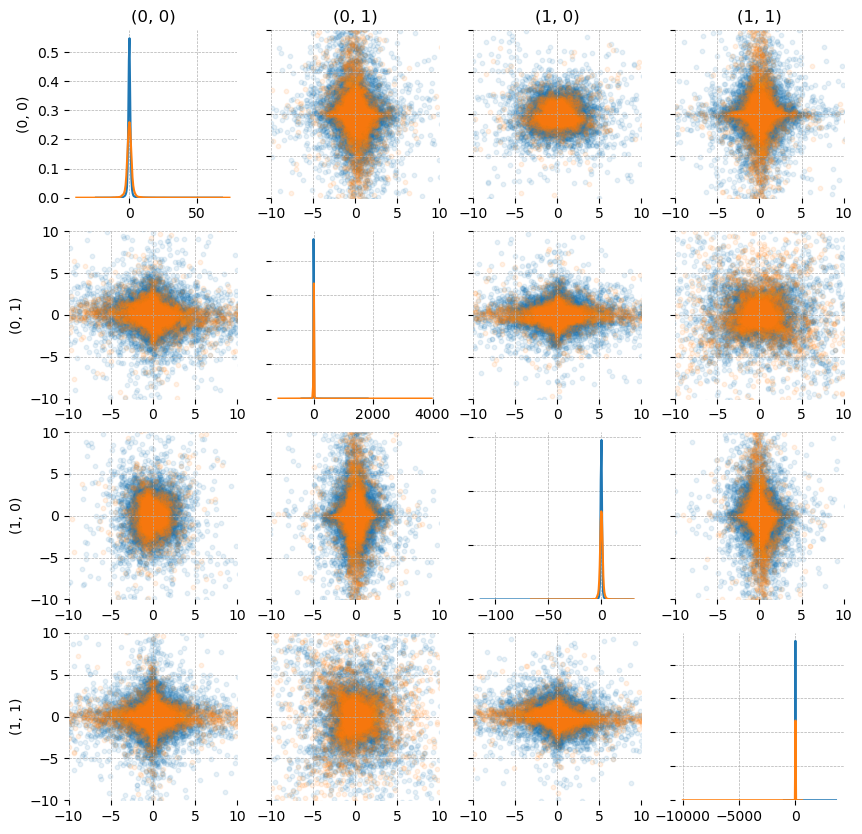

In [47]:
import seaborn as sns
fig, ax = plt.subplots(4, 4, figsize=(10, 10), sharex=False)
P1_samples = prior.prior.params_1.sel(equation=0).values.squeeze()
P2_samples = prior.prior.params_2.sel(equation=0).values.squeeze()
coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i, x in enumerate(coords):
    for j, y in enumerate(coords):
        axis = ax[i][j]        
        if i == j:
            sns.kdeplot(x=P1_samples[:, x[0], x[1]], ax=axis)
            sns.kdeplot(x=P2_samples[:, x[0], x[1]], ax=axis)
            axis.set(ylabel='')
        else:
            axis.scatter(P2_samples[:, x[0], x[1]], P2_samples[:, y[0], y[1]], s=10, alpha=0.1)
            axis.scatter(P1_samples[:, x[0], x[1]], P1_samples[:, y[0], y[1]], s=10, alpha=0.1)
            axis.set_xlim(-10, 10)
            axis.set_ylim(-10, 10)
        if i == 0:
            axis.set(title=y)
        if j == 0:
            axis.set(ylabel=x)
        else:
            axis.tick_params(axis='y', labelleft=False)


Regardless of those crazy prior values, the prior produces only stable parameter matrices as promised!

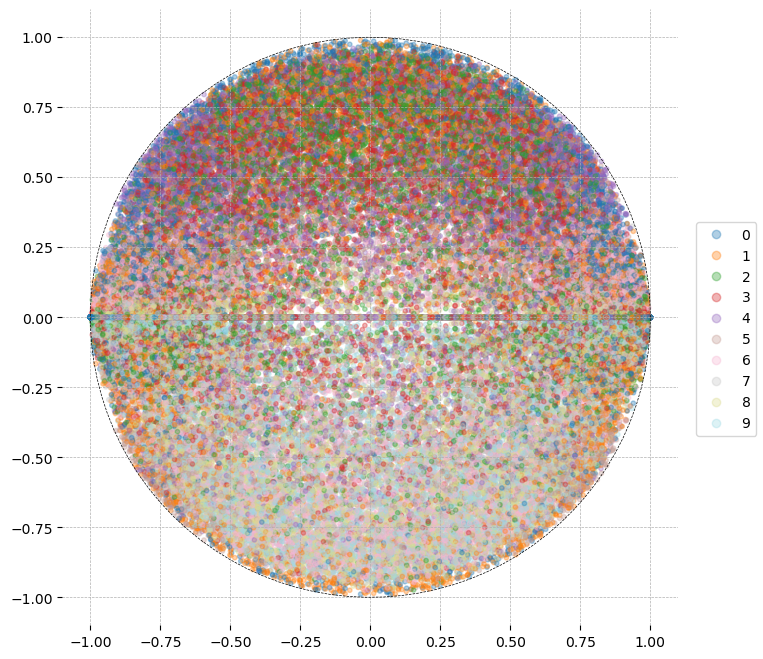

In [48]:
P1_samples = prior.prior.params_1.values.squeeze().transpose(0,2,1,3)
P1_samples = np.ascontiguousarray(P1_samples)
eigs = stability_analysis(P1_samples)
plot_eigenvalues(eigs, include_kde=False)

In [44]:
def build_Heaps_VAR(df, n_lags):
    n_eq = df.shape[1]
    k_offdiag = n_eq * (n_eq - 1)

    start_idx = n_lags
    coords={"lag": np.arange(n_lags) + 1,
            "equation": df.columns.tolist(),
            "var": df.columns.tolist(),
            'position':['diag', 'off-diag'],
            "time": [f'{x.year}Q{x.quarter}' for x in df.index[start_idx:]]}
    
    with pm.Model(coords=coords) as model:        
        data = pm.Data('data', df.values, mutable=True)
        data_obs = pm.Data('data_obs', df.values[start_idx:], dims=['time', 'equations'], mutable=True)
        
        chol, corr, stds = pm.LKJCholeskyCov('sigma_chol', eta=1.0, sd_dist=pm.HalfNormal.dist(sigma=1.0), n=n_eq)
        Sigma = pm.Deterministic('Sigma', chol.dot(chol.T))

        A_mu = pm.Normal('A_mu', mu=0, sigma=np.sqrt(0.35), dims=['position', 'lag'])
        A_tau = pm.Gamma('A_tau', alpha=1.05, beta=0.0075, dims=['position', 'lag'])
        A_diag = pm.Normal('A_diag', mu=A_mu[0], tau=A_tau[0], dims=['equation', 'lag']).T

        # I don't think we can have nice coords for this, it's the unraveled lower-triangular part
        # of a VAR filter
        A_offdiag = pm.Normal('A_offdiag', mu=A_mu[1], tau=A_tau[1], size=(k_offdiag, n_lags)).T

        # These are the convolutional filters in R(m x m)
        # We need to organize things so that lags are the "batch dimension", since the reverse-mapping iterates 
        # in the lag dimension
        A = pm.Deterministic('A', build_A_matrix(A_diag, A_offdiag, n_lags, n_eq))
        P = pm.Deterministic('P', A_to_P(A), dims=['lag', 'equation', 'var'])    
        lag_coefs = pm.Deterministic('params', P_to_params(P, Sigma)[0], dims=['lag', 'equation', 'var'])
        lag_coefs = lag_coefs.transpose(1,0,2) # transpose to equation, lag, var for convolution
        
        # Each convolution produces the prediction for time t+1. As a result we have to drop the last row of data,
        # since we don't have an observation that goes with it. For example, the first 4 x 3 block of data makes 
        # a precition for t=5 (4 lags)
        
        # Flip the lags so the first row of the output is the 1st lag, rather than the 4th. This makes
        # switching to the state space representation more convenient.
        VAR_equations = at.nnet.conv2d(input=at.expand_dims(data[:-1], axis=(0, 1)), # add batch_size = in_filters = 1
                                       filters=at.expand_dims(lag_coefs, axis=1)[:, :, ::-1, :], # add in_filters = 1
                                       border_mode='valid', 
                                       filter_flip=False)
        
        mean = VAR_equations[0, :, :, 0].T
        obs = pm.MvNormal('obs', mu=mean, chol=chol, observed=data_obs, dims=['time', 'equations'])
            
    return model

# Var(32,4)

Once more with feeling. I'll just use the "default" prior provided by Heaps.

Sadly this doesn't sample well, still to work out the details!

In [ ]:
# VAR_32_heaps = build_Heaps_VAR(train_df.iloc[:, :20].dropna(), n_lags=4)
# with VAR_32_heaps:
#     trace_32 = pm.sample(init='jitter+adapt_full')